In [1]:
import scipy.integrate as spint
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
#NEEDED TO READ IN DATA FROM A TEXT FILE (CSV)
import pandas as pd
#NEEDED TO UPLOAD A FILE INTO COLAB PLATFORM
# from google.colab import files
import pandas as pd
import seaborn as sns
import xarray as xr

Loading wetlands and antropogenic emissions data in NH and SH

In [2]:
ch4_emission_all_nh = xr.open_dataset('ch4_antropogenic_emissions_zonal_model_mean.nc', decode_times=True)\
                    .ch4_antro[480:,180:].sum('lat') * 1e-6 * 12 / 2
ch4_emission_all_sh = xr.open_dataset('ch4_antropogenic_emissions_zonal_model_mean.nc', decode_times=True)\
                    .ch4_antro[480:,:180].sum('lat') * 1e-6 * 12 / 2
wet_emission_all_nh = xr.open_dataset('wetland_emissions_zonal_model_mean.nc', decode_times=True)\
                    .wetland_emissions[108:-12,180:].sum('lat') * 1e-12 * 12 / 2
wet_emission_all_sh = xr.open_dataset('wetland_emissions_zonal_model_mean.nc', decode_times=True)\
                    .wetland_emissions[108:-12,:180].sum('lat') * 1e-12 * 12 / 2
# ch4_emission_all = ch4_emission_all[480:,:].sum('lat')

emission_total_all_nh = (wet_emission_all_nh + ch4_emission_all_nh)
emission_total_all_nh = emission_total_all_nh.assign_coords(time = np.arange(1,61,1))
emission_total_all_nh = emission_total_all_nh.interp(time=np.arange(1,61,0.1))

emission_total_all_sh = (wet_emission_all_sh + ch4_emission_all_h)
emission_total_all_sh = emission_total_all_sh.assign_coords(time = np.arange(1,61,1))
emission_total_all_sh = emission_total_all_sh.interp(time=np.arange(1,61,0.1))

Loading total CH$_4$ loss from GFDL model. 

In [3]:
x = xr.open_dataset('OH_LCH4_concentrations_zonal_mean_r1.nc')
lch4_VMR_nh = (x.LCH4_VMR_s_zonal_mean.mean('p').sel(lat=slice(0,90)).sum('lat') * 24 * 60 * 60 * 1e9).\
                interp(month=np.arange(1,12.01,0.1))
lch4_VMR_sh = (x.LCH4_VMR_s_zonal_mean.mean('p').sel(lat=slice(-90,0)).sum('lat') * 24 * 60 * 60 * 1e9).\
                interp(month=np.arange(1,12.01,0.1))
lch4_nh = x.LCH4_zonal_mean.sum('p').sel(lat=slice(0,90)).sum('lat').interp(month=np.arange(1,12.01,0.1))
lch4_sh = x.LCH4_zonal_mean.sum('p').sel(lat=slice(-90,0)).sum('lat').interp(month=np.arange(1,12.01,0.1))

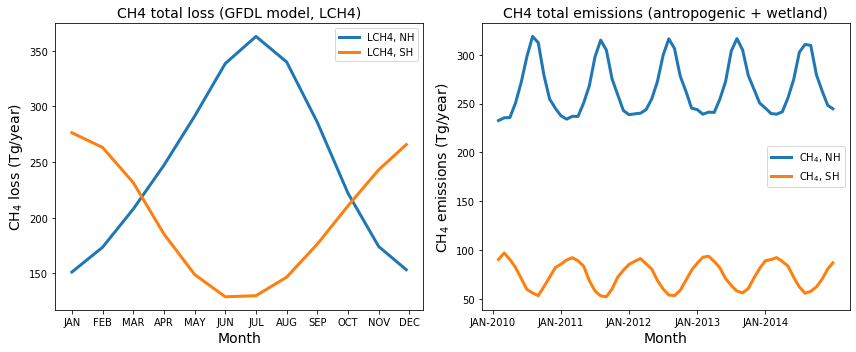

In [20]:
months = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

fig = plt.figure(figsize=[6,5])
fig.set_figwidth(fig.get_figwidth() * 2)
# fig.set_figheight(fig.get_figheight() * 2)

ax = fig.add_subplot(1,2,1)
(lch4_nh*1e-11).plot(label = 'LCH4, NH',linewidth=3)
(lch4_sh*1e-11).plot(label = 'LCH4, SH',linewidth=3)
plt.ylabel('CH$_4$ loss (Tg/year)', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title('CH4 total loss (GFDL model, LCH4)', fontsize=14)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], months)
plt.tight_layout()

ax = fig.add_subplot(1,2,2)
emission_total_all_nh.plot(linewidth=3, label='CH$_4$, NH')
emission_total_all_sh.plot(linewidth=3, label='CH$_4$, SH')
plt.ylabel('CH$_4$ emissions (Tg/year)', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title('CH4 total emissions (antropogenic + wetland)', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

plt.tight_layout()
plt.savefig('figures/2_box_LCH4_emission_loss.pdf')

 ## 2-box model run with Total emission (wet + antro)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/integrate/_ivp/rk.py:144: RuntimeWarning: invalid value encountered in maximum
  scale = atol + np.maximum(np.abs(y), np.abs(y_new)) * rtol


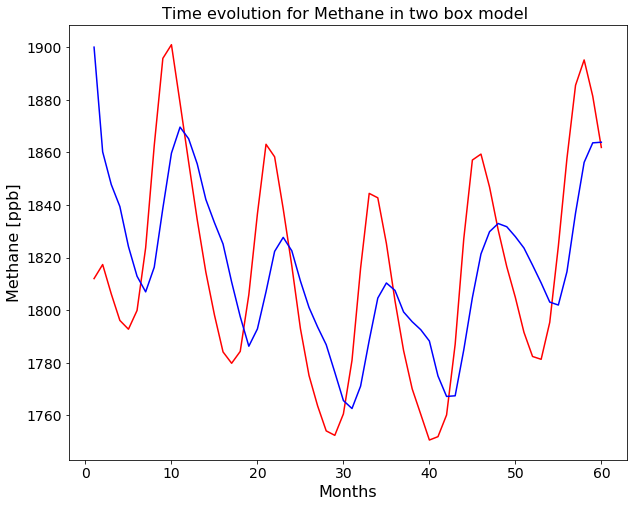

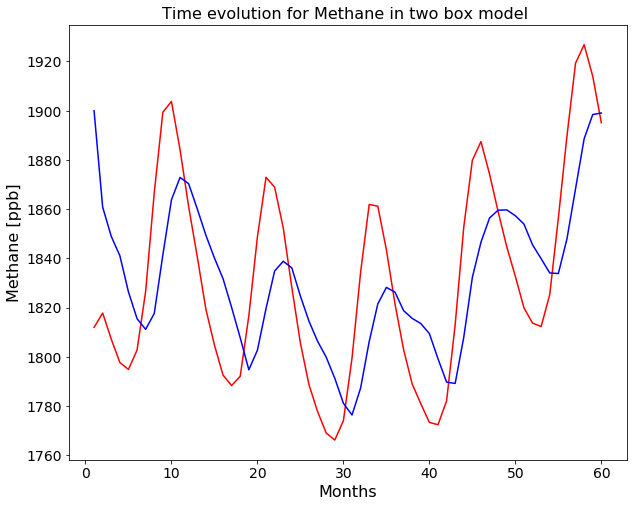

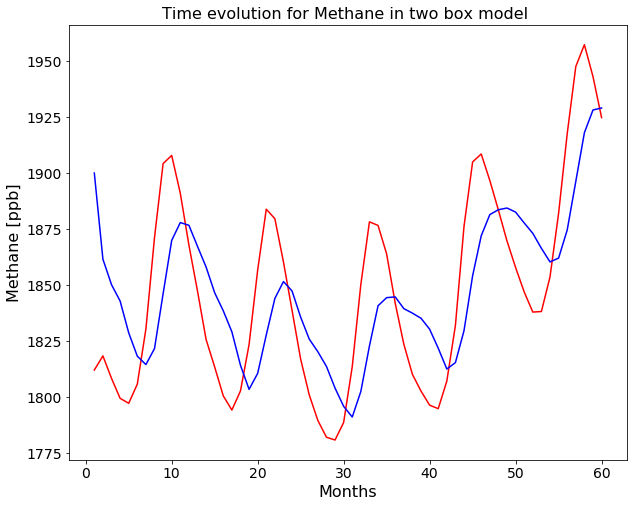

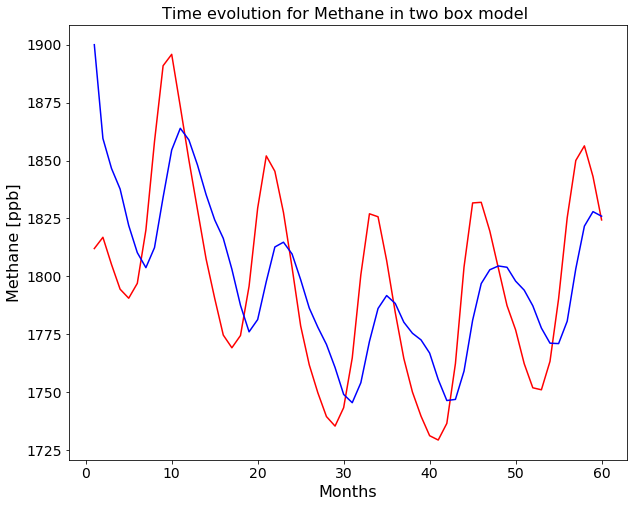

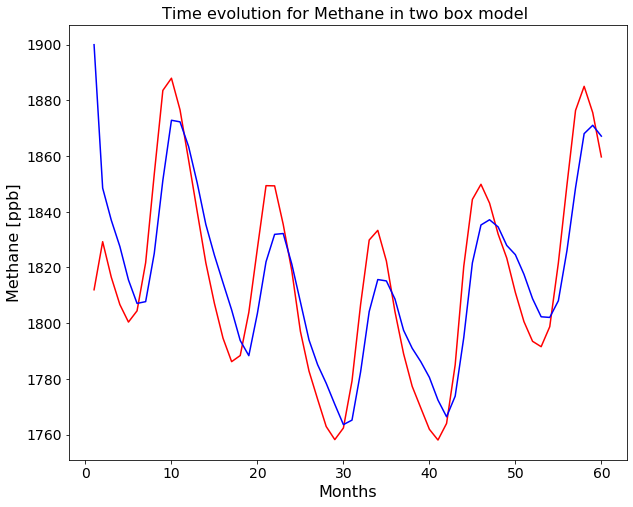

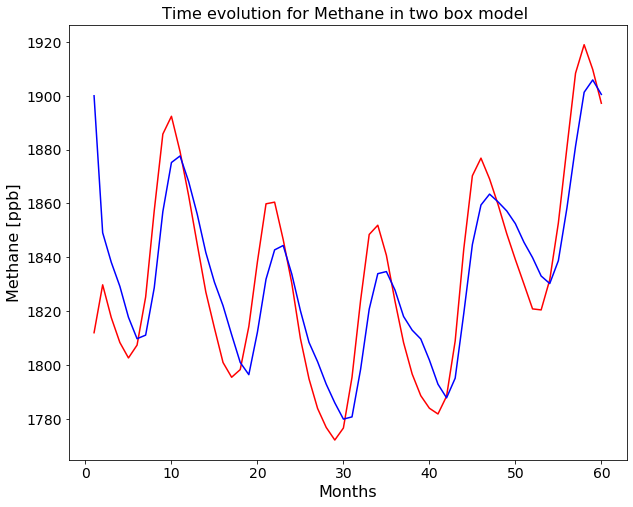

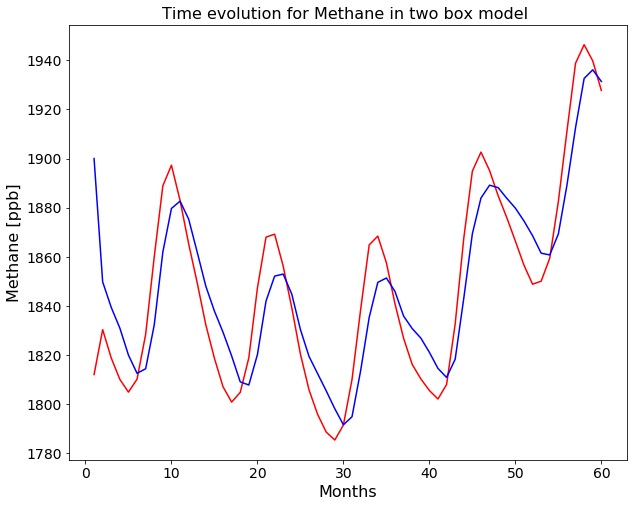

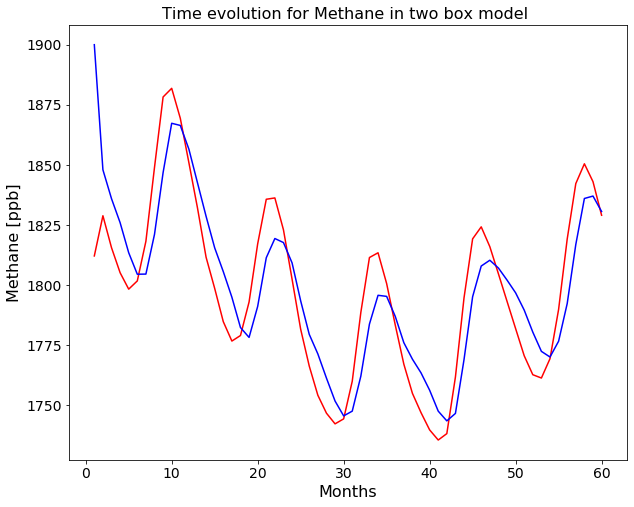

In [5]:
class twobox_tvaryoh():
    """ two box model for methane mass in the atmosphere"""
    
    def __init__(self, mass_atm=5.2e9, mwair=.029, mwch4=.016):
        """ constructor
        
        PARAMETERS:
        
        mass_atm: float
            mass of atmosphere in Tg; converted below to tropospheric mass for consistency with earlier problem
        mwair: float
            molecular weight of dry air in kg/mol
        mwch4: float
            molecular weight of methane in kg/mol
   
        """
        self.mass_atm = mass_atm*.9
        self.mwair = mwair
        self.mwch4 = mwch4
        self.conv = self.mass_atm*1e-9*mwch4/mwair
        return None

    def integrate_tracer(self, name='Methane', emis=5.2e2, nhemisfrac=0.75, nhOH=0., ohperiod=30., ohamp=.15, chem_loss=1./9., tauNS=1.0,
                        concNH_ini=1812., concSH_ini=1900., time_ini=0, run_duration=60, time_offset=1,tstep=1, k=0.01):
        """ time integration of the two box equation`
        
        PARAMETERS:
        
        name: str
            name of the chemical species
        emis: float
            Total global methane emissions to the atmosphere in Tg/y
        nhemisfrac: float
            Fraction of total emissions occurring within the northern hemisphere
        nhOH: float
            Percentage by which to increase the loss rate (due to differences in OH) in NH and decrease in SH
        ohperiod: float
            Period for OH oscillation in years
        ohamp: float
            Amplitude of OH oscillation as percentage
        chem_loss: float
            Total removal rate due to chemical loss from the atmosphere in 1/year 
        tauNS: float
            Exchange rate between northern and southern hemispheres, in years
        concNH_ini: float
            initial concentration of chemical species in ppb in NH
        concSH_ini: float
            initial concentration of cheimcal species in ppb in SH
        time_ini: float
            starting time
        run_duration: float
            integration time in years
        time_offset: float
            time from year 0 at which integration begins 
        tstep: float
            time step for integration in years
        """
        self.name = name
        self.k = k
#         self.emis = emis
        self.emisNH = emis*nhemisfrac
        self.emisSH = emis*(1-nhemisfrac)
        self.tauNS = tauNS
        self.ohperiod = ohperiod
        self.ohamp = ohamp
        #print('CHEM_LOSS=',chem_loss)
#         self.chem_lossNH = chem_loss+(chem_loss*nhOH)
#         self.chem_lossSH = chem_loss-(chem_loss*nhOH)
        #print('N, S, AVGNS = ',self.chem_lossNH, self.chem_lossSH, ((self.chem_lossNH+self.chem_lossSH)/2.))
        self.conc_ini = np.array([concNH_ini,concSH_ini])
        self.mass_ini = self.conc_ini*(self.conv/2.)
        self.time_ini = time_ini
        self.time_end = run_duration
        self.time_offset = time_offset
        self.tstep = np.arange(self.time_end-self.time_ini)/tstep
        
        
        # integrate the box equation with RK45
        # Need vectorized to be true for more than one equation
        solver = spint.solve_ivp(self.methane_twobox_equations, (self.time_ini, self.time_end,),
                                 self.mass_ini, method='RK45', t_eval=self.tstep, vectorized='True')
   
     
        self.time = solver['t']
        #print(self.time)
        self.tracer_mass = solver['y'].squeeze()
        #convert mass back to mixing ratio
        self.tracer_ppb =self.tracer_mass/(self.conv/2.)
        # plot the results
        self.plot_timeserie()
        return self.time, self.tracer_ppb

              
    def plot_timeserie(self):
        """ plotting function """
        plt.figure(figsize=[10,8])
        plt.plot(self.time+self.time_offset, self.tracer_ppb[0], color='red')
        plt.plot(self.time+self.time_offset, self.tracer_ppb[1], color='blue')
        plt.xlabel('Months',fontsize=16)
        plt.ylabel(self.name + ' [ppb]', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Time evolution for ' + self.name + 
                  ' in two box model ', fontsize=16)
        return None
        
    def methane_twobox_equations(self, time_rk45, mass):
        """ governing equation """ 
        # budget adjustment
        budget_adjust_nh = np.array(((ch4_emission_all_nh+wet_emission_all_nh)*self.conv).mean() - lch4_VMR_nh.mean())
        budget_adjust_sh = np.array(((ch4_emission_all_sh+wet_emission_all_sh)*self.conv).mean() - lch4_VMR_sh.mean())
        
        # emissions
        E_nh = np.array(emission_total_all_nh.sel(time = time_rk45, method='nearest'))
        E_sh = np.array(emission_total_all_sh.sel(time = time_rk45, method='nearest'))

        # total CH4 removal
        removal_total_nh = np.array(lch4_VMR_nh.sel(month = time_rk45 % 12, method = 'nearest'))
        removal_total_sh = np.array(lch4_VMR_sh.sel(month = time_rk45 % 12, method = 'nearest'))

#         dmdt =  (E*self.conv - budget_adjust) -  self.k*(removal_total)
                
#         dMnhdt = E_nh - self.k * ( vary_oh_lossNH * mass[0] ) + ((mass[1]-mass[0])/self.tauNS)
#         dMshdt = E_sh - self.k * ( vary_oh_lossSH * mass[1] ) + ((mass[0]-mass[1])/self.tauNS)
        
        dMnhdt = (E_nh*self.conv - budget_adjust_nh) - self.k * removal_total_nh + ((mass[1]-mass[0])/self.tauNS)
        dMshdt = (E_sh*self.conv - budget_adjust_sh) - self.k * removal_total_sh + ((mass[0]-mass[1])/self.tauNS)
        
        return np.array([dMnhdt, dMshdt])
boxmodel_tvaryoh = twobox_tvaryoh()
t_2b_lch4_1_1, ch4_conc_2b_lch4_1_1 = boxmodel_tvaryoh.integrate_tracer(k = 1, tauNS = 1)
t_2b_lch4_1_2, ch4_conc_2b_lch4_1_2 = boxmodel_tvaryoh.integrate_tracer(k = 0.98, tauNS = 1)
t_2b_lch4_1_3, ch4_conc_2b_lch4_1_3 = boxmodel_tvaryoh.integrate_tracer(k = 0.96, tauNS = 1)
t_2b_lch4_1_4, ch4_conc_2b_lch4_1_4 = boxmodel_tvaryoh.integrate_tracer(k = 1.02, tauNS = 1)

t_2b_lch4_1_11, ch4_conc_2b_lch4_1_11 = boxmodel_tvaryoh.integrate_tracer(k = 1, tauNS = 0.5)
t_2b_lch4_1_21, ch4_conc_2b_lch4_1_21 = boxmodel_tvaryoh.integrate_tracer(k = 0.98, tauNS = 0.5)
t_2b_lch4_1_31, ch4_conc_2b_lch4_1_31 = boxmodel_tvaryoh.integrate_tracer(k = 0.96, tauNS = 0.5)
t_2b_lch4_1_41, ch4_conc_2b_lch4_1_41 = boxmodel_tvaryoh.integrate_tracer(k = 1.02, tauNS = 0.5)

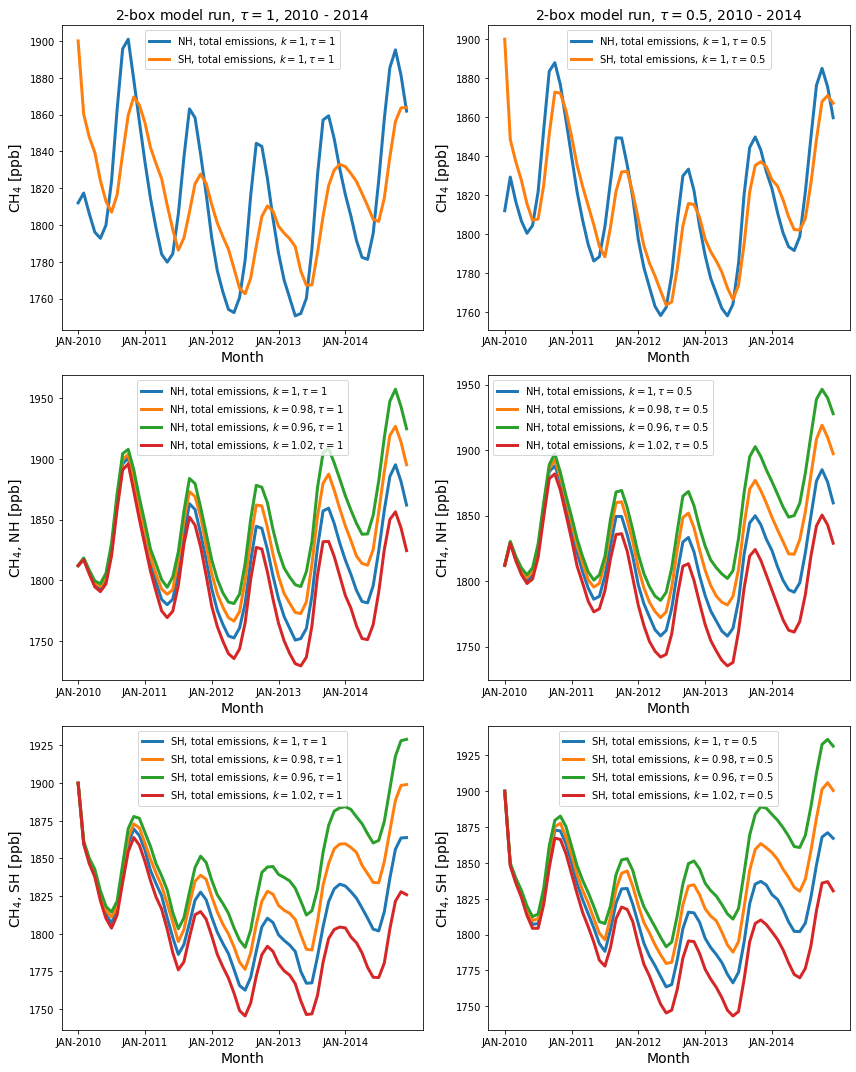

In [6]:
fig = plt.figure(figsize=[6,5])
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 3)

ax = fig.add_subplot(3,2,1)
plt.plot(ch4_conc_2b_lch4_1_1[0], linewidth=3, label=r'NH, total emissions, $k=1, \tau=1$')
plt.plot(ch4_conc_2b_lch4_1_1[1], linewidth=3, label=r'SH, total emissions, $k=1,\tau=1$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, $\tau = 1$, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(3,2,2)
plt.plot(ch4_conc_2b_lch4_1_11[0], linewidth=3, label=r'NH, total emissions, $k=1, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_1_11[1], linewidth=3, label=r'SH, total emissions, $k=1,\tau=0.5$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, $\tau = 0.5$, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(3,2,3)
plt.plot(ch4_conc_2b_lch4_1_1[0], linewidth=3, label=r'NH, total emissions, $k=1, \tau=1$')
plt.plot(ch4_conc_2b_lch4_1_2[0], linewidth=3, label=r'NH, total emissions, $k=0.98, \tau=1$')
plt.plot(ch4_conc_2b_lch4_1_3[0], linewidth=3, label=r'NH, total emissions, $k=0.96, \tau=1$')
plt.plot(ch4_conc_2b_lch4_1_4[0], linewidth=3, label=r'NH, total emissions, $k=1.02, \tau=1$')
plt.ylabel('CH$_4$, NH [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
# plt.title('2-box model run, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(3,2,4)
plt.plot(ch4_conc_2b_lch4_1_11[0], linewidth=3, label=r'NH, total emissions, $k=1, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_1_21[0], linewidth=3, label=r'NH, total emissions, $k=0.98, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_1_31[0], linewidth=3, label=r'NH, total emissions, $k=0.96, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_1_41[0], linewidth=3, label=r'NH, total emissions, $k=1.02, \tau=0.5$')
plt.ylabel('CH$_4$, NH [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
# plt.title('2-box model run, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(3,2,5)
plt.plot(ch4_conc_2b_lch4_1_1[1], linewidth=3, label=r'SH, total emissions, $k=1, \tau=1$')
plt.plot(ch4_conc_2b_lch4_1_2[1], linewidth=3, label=r'SH, total emissions, $k=0.98, \tau=1$')
plt.plot(ch4_conc_2b_lch4_1_3[1], linewidth=3, label=r'SH, total emissions, $k=0.96, \tau=1$')
plt.plot(ch4_conc_2b_lch4_1_4[1], linewidth=3, label=r'SH, total emissions, $k=1.02, \tau=1$')
plt.ylabel('CH$_4$, SH [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
# plt.title('2-box model run, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(3,2,6)
plt.plot(ch4_conc_2b_lch4_1_11[1], linewidth=3, label=r'SH, total emissions, $k=1, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_1_21[1], linewidth=3, label=r'SH, total emissions, $k=0.98, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_1_31[1], linewidth=3, label=r'SH, total emissions, $k=0.96, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_1_41[1], linewidth=3, label=r'SH, total emissions, $k=1.02, \tau=0.5$')
plt.ylabel('CH$_4$, SH [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
# plt.title('2-box model run, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

plt.tight_layout()
plt.savefig('figures/2_box_LCH4_5_year_timeseries_all_cases.pdf')

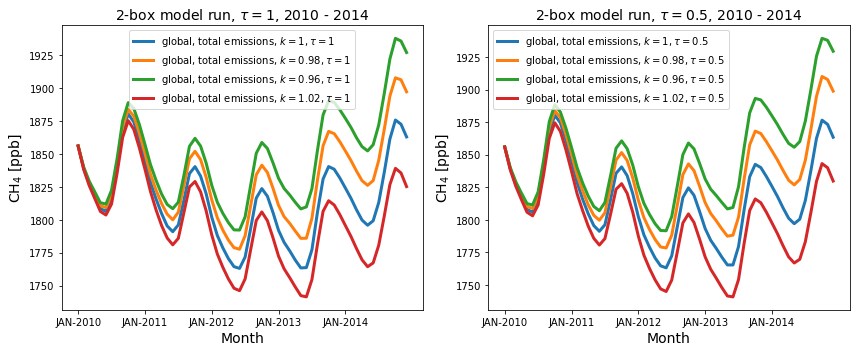

In [40]:
fig = plt.figure(figsize=[6,5])
fig.set_figwidth(fig.get_figwidth() * 2)
# fig.set_figheight(fig.get_figheight() * 3)

ax = fig.add_subplot(1,2,1)
plt.plot((ch4_conc_2b_lch4_1_1[0] + ch4_conc_2b_lch4_1_1[1])/2, linewidth=3, label=r'global, total emissions, $k=1, \tau=1$')
plt.plot((ch4_conc_2b_lch4_1_2[0] + ch4_conc_2b_lch4_1_2[1])/2, linewidth=3, label=r'global, total emissions, $k=0.98, \tau=1$')
plt.plot((ch4_conc_2b_lch4_1_3[0] + ch4_conc_2b_lch4_1_3[1])/2, linewidth=3, label=r'global, total emissions, $k=0.96, \tau=1$')
plt.plot((ch4_conc_2b_lch4_1_4[0] + ch4_conc_2b_lch4_1_4[1])/2, linewidth=3, label=r'global, total emissions, $k=1.02, \tau=1$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, $\tau = 1$, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(1,2,2)
plt.plot((ch4_conc_2b_lch4_1_11[0] + ch4_conc_2b_lch4_1_11[1])/2, linewidth=3, label=r'global, total emissions, $k=1, \tau=0.5$')
plt.plot((ch4_conc_2b_lch4_1_21[0] + ch4_conc_2b_lch4_1_21[1])/2, linewidth=3, label=r'global, total emissions, $k=0.98, \tau=0.5$')
plt.plot((ch4_conc_2b_lch4_1_31[0] + ch4_conc_2b_lch4_1_31[1])/2, linewidth=3, label=r'global, total emissions, $k=0.96, \tau=0.5$')
plt.plot((ch4_conc_2b_lch4_1_41[0] + ch4_conc_2b_lch4_1_41[1])/2, linewidth=3, label=r'global, total emissions, $k=1.02, \tau=0.5$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, $\tau = 0.5$, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

plt.tight_layout()
plt.savefig('figures/2_box_LCH4_5_year_timeseries.pdf')

In [8]:
# tau = 1
mean_monthly_nh_1_1 = (ch4_conc_2b_lch4_1_1[0][:12] + ch4_conc_2b_lch4_1_1[0][12:24] + ch4_conc_2b_lch4_1_1[0][24:36]\
               + ch4_conc_2b_lch4_1_1[0][36:48] + ch4_conc_2b_lch4_1_1[0][48:])/5
mean_monthly_sh_1_1 = (ch4_conc_2b_lch4_1_1[1][:12] + ch4_conc_2b_lch4_1_1[1][12:24] + ch4_conc_2b_lch4_1_1[1][24:36]\
               + ch4_conc_2b_lch4_1_1[1][36:48] + ch4_conc_2b_lch4_1_1[1][48:])/5
mean_monthly_global_1_1 = (mean_monthly_nh_1_1 + mean_monthly_sh_1_1) / 2 


mean_monthly_nh_1_2 = (ch4_conc_2b_lch4_1_2[0][:12] + ch4_conc_2b_lch4_1_2[0][12:24] + ch4_conc_2b_lch4_1_2[0][24:36]\
               + ch4_conc_2b_lch4_1_2[0][36:48] + ch4_conc_2b_lch4_1_2[0][48:])/5
mean_monthly_sh_1_2 = (ch4_conc_2b_lch4_1_2[1][:12] + ch4_conc_2b_lch4_1_2[1][12:24] + ch4_conc_2b_lch4_1_2[1][24:36]\
               + ch4_conc_2b_lch4_1_2[1][36:48] + ch4_conc_2b_lch4_1_2[1][48:])/5
mean_monthly_global_1_2 = (mean_monthly_nh_1_2 + mean_monthly_sh_1_2) / 2 


mean_monthly_nh_1_3 = (ch4_conc_2b_lch4_1_3[0][:12] + ch4_conc_2b_lch4_1_3[0][12:24] + ch4_conc_2b_lch4_1_3[0][24:36]\
               + ch4_conc_2b_lch4_1_3[0][36:48] + ch4_conc_2b_lch4_1_3[0][48:])/5
mean_monthly_sh_1_3 = (ch4_conc_2b_lch4_1_3[1][:12] + ch4_conc_2b_lch4_1_3[1][12:24] + ch4_conc_2b_lch4_1_3[1][24:36]\
               + ch4_conc_2b_lch4_1_3[1][36:48] + ch4_conc_2b_lch4_1_3[1][48:])/5
mean_monthly_global_1_3 = (mean_monthly_nh_1_3 + mean_monthly_sh_1_3) / 2 


mean_monthly_nh_1_4 = (ch4_conc_2b_lch4_1_4[0][:12] + ch4_conc_2b_lch4_1_4[0][12:24] + ch4_conc_2b_lch4_1_4[0][24:36]\
               + ch4_conc_2b_lch4_1_4[0][36:48] + ch4_conc_2b_lch4_1_4[0][48:])/5
mean_monthly_sh_1_4 = (ch4_conc_2b_lch4_1_4[1][:12] + ch4_conc_2b_lch4_1_4[1][12:24] + ch4_conc_2b_lch4_1_4[1][24:36]\
               + ch4_conc_2b_lch4_1_4[1][36:48] + ch4_conc_2b_lch4_1_4[1][48:])/5
mean_monthly_global_1_4 = (mean_monthly_nh_1_4 + mean_monthly_sh_1_4) / 2

# tau = 0.5 
mean_monthly_nh_1_11 = (ch4_conc_2b_lch4_1_11[0][:12] + ch4_conc_2b_lch4_1_11[0][12:24] + ch4_conc_2b_lch4_1_11[0][24:36]\
               + ch4_conc_2b_lch4_1_11[0][36:48] + ch4_conc_2b_lch4_1_11[0][48:])/5
mean_monthly_sh_1_11 = (ch4_conc_2b_lch4_1_11[1][:12] + ch4_conc_2b_lch4_1_11[1][12:24] + ch4_conc_2b_lch4_1_11[1][24:36]\
               + ch4_conc_2b_lch4_1_11[1][36:48] + ch4_conc_2b_lch4_1_11[1][48:])/5
mean_monthly_global_1_11 = (mean_monthly_nh_1_11 + mean_monthly_sh_1_11) / 2 


mean_monthly_nh_1_21 = (ch4_conc_2b_lch4_1_21[0][:12] + ch4_conc_2b_lch4_1_21[0][12:24] + ch4_conc_2b_lch4_1_21[0][24:36]\
               + ch4_conc_2b_lch4_1_21[0][36:48] + ch4_conc_2b_lch4_1_21[0][48:])/5
mean_monthly_sh_1_21 = (ch4_conc_2b_lch4_1_21[1][:12] + ch4_conc_2b_lch4_1_21[1][12:24] + ch4_conc_2b_lch4_1_21[1][24:36]\
               + ch4_conc_2b_lch4_1_21[1][36:48] + ch4_conc_2b_lch4_1_21[1][48:])/5
mean_monthly_global_1_21 = (mean_monthly_nh_1_21 + mean_monthly_sh_1_21) / 2 


mean_monthly_nh_1_31 = (ch4_conc_2b_lch4_1_31[0][:12] + ch4_conc_2b_lch4_1_31[0][12:24] + ch4_conc_2b_lch4_1_31[0][24:36]\
               + ch4_conc_2b_lch4_1_31[0][36:48] + ch4_conc_2b_lch4_1_31[0][48:])/5
mean_monthly_sh_1_31 = (ch4_conc_2b_lch4_1_31[1][:12] + ch4_conc_2b_lch4_1_31[1][12:24] + ch4_conc_2b_lch4_1_31[1][24:36]\
               + ch4_conc_2b_lch4_1_31[1][36:48] + ch4_conc_2b_lch4_1_31[1][48:])/5
mean_monthly_global_1_31 = (mean_monthly_nh_1_31 + mean_monthly_sh_1_31) / 2 


mean_monthly_nh_1_41 = (ch4_conc_2b_lch4_1_41[0][:12] + ch4_conc_2b_lch4_1_41[0][12:24] + ch4_conc_2b_lch4_1_41[0][24:36]\
               + ch4_conc_2b_lch4_1_41[0][36:48] + ch4_conc_2b_lch4_1_41[0][48:])/5
mean_monthly_sh_1_41 = (ch4_conc_2b_lch4_1_41[1][:12] + ch4_conc_2b_lch4_1_41[1][12:24] + ch4_conc_2b_lch4_1_41[1][24:36]\
               + ch4_conc_2b_lch4_1_41[1][36:48] + ch4_conc_2b_lch4_1_41[1][48:])/5
mean_monthly_global_1_41 = (mean_monthly_nh_1_41 + mean_monthly_sh_1_41) / 2

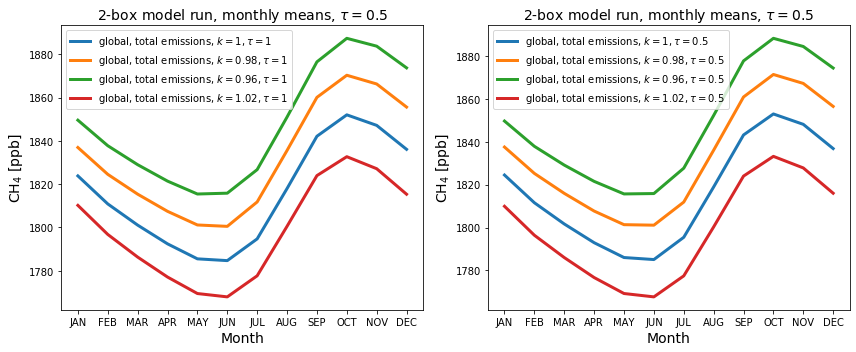

In [9]:

fig = plt.figure(figsize=[6,5])
fig.set_figwidth(fig.get_figwidth() * 2)
# fig.set_figheight(fig.get_figheight() * 2)

ax = fig.add_subplot(1,2,1)
plt.plot(mean_monthly_global_1_1, linewidth=3, label=r'global, total emissions, $k=1, \tau=1$')
plt.plot(mean_monthly_global_1_2, linewidth=3, label=r'global, total emissions, $k=0.98, \tau=1$')
plt.plot(mean_monthly_global_1_3, linewidth=3, label=r'global, total emissions, $k=0.96, \tau=1$')
plt.plot(mean_monthly_global_1_4, linewidth=3, label=r'global, total emissions, $k=1.02, \tau=1$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, monthly means, $\tau = 0.5$', fontsize=14)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], months)
plt.tight_layout()

ax = fig.add_subplot(1,2,2)
plt.plot(mean_monthly_global_1_11, linewidth=3, label=r'global, total emissions, $k=1, \tau=0.5$')
plt.plot(mean_monthly_global_1_21, linewidth=3, label=r'global, total emissions, $k=0.98, \tau=0.5$')
plt.plot(mean_monthly_global_1_31, linewidth=3, label=r'global, total emissions, $k=0.96, \tau=0.5$')
plt.plot(mean_monthly_global_1_41, linewidth=3, label=r'global, total emissions, $k=1.02, \tau=0.5$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, monthly means, $\tau = 0.5$', fontsize=14)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], months)
plt.tight_layout()

plt.tight_layout()
plt.savefig('figures/2_box_LCH4_5_year_monthly_means.pdf')

## 2-box model with with Antropogenic emission only 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/integrate/_ivp/rk.py:144: RuntimeWarning: invalid value encountered in maximum
  scale = atol + np.maximum(np.abs(y), np.abs(y_new)) * rtol


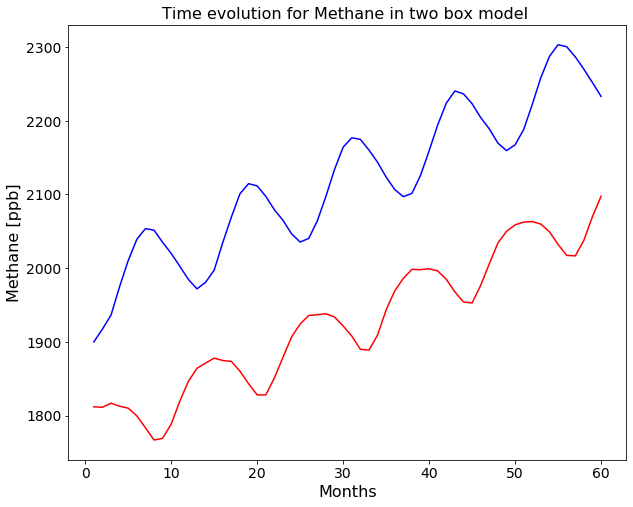

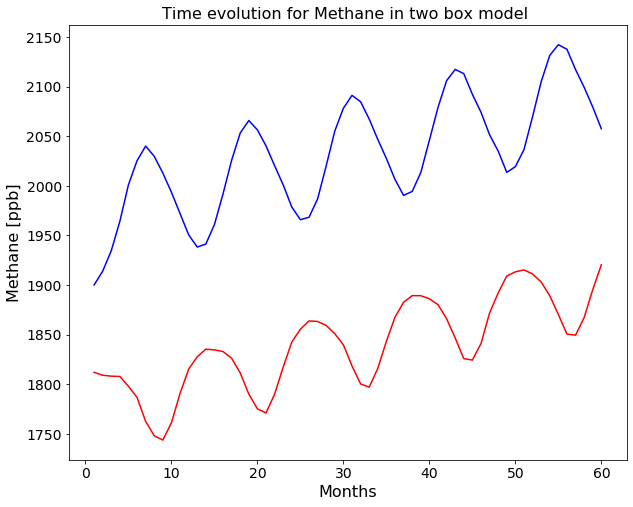

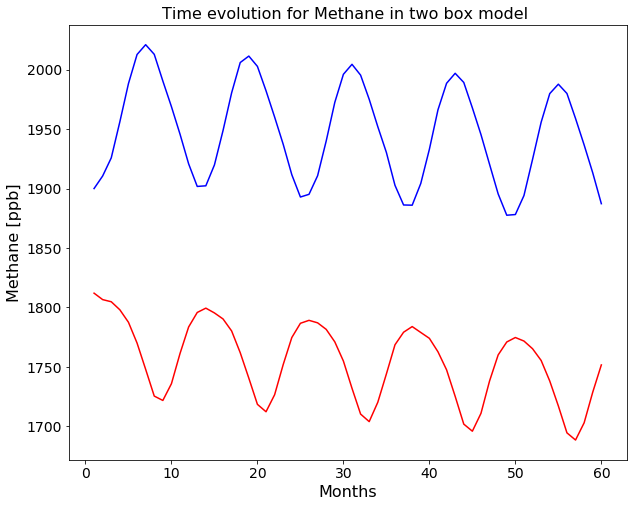

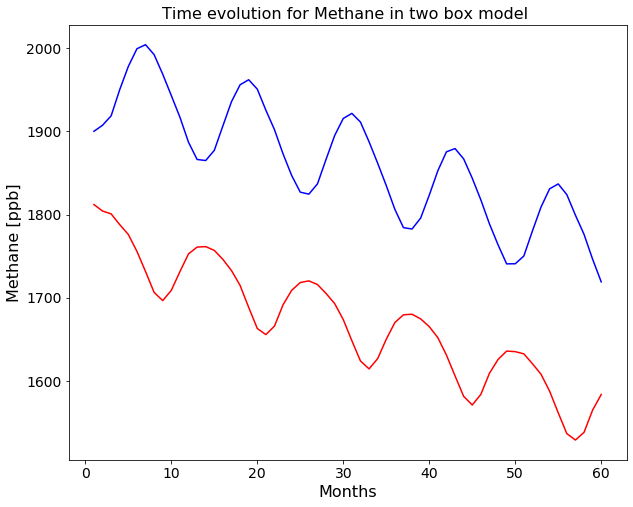

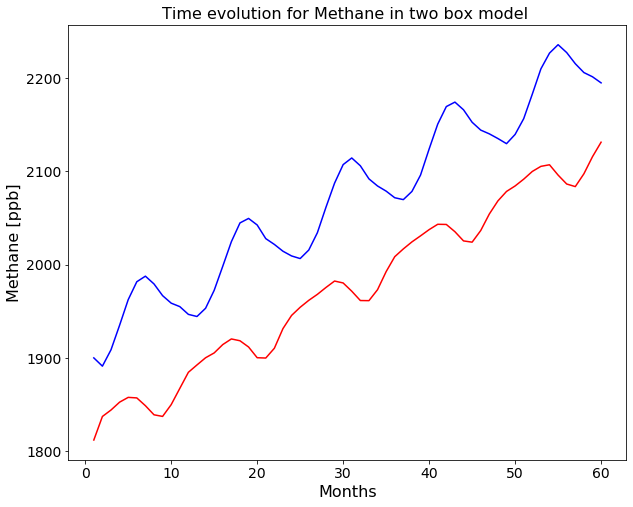

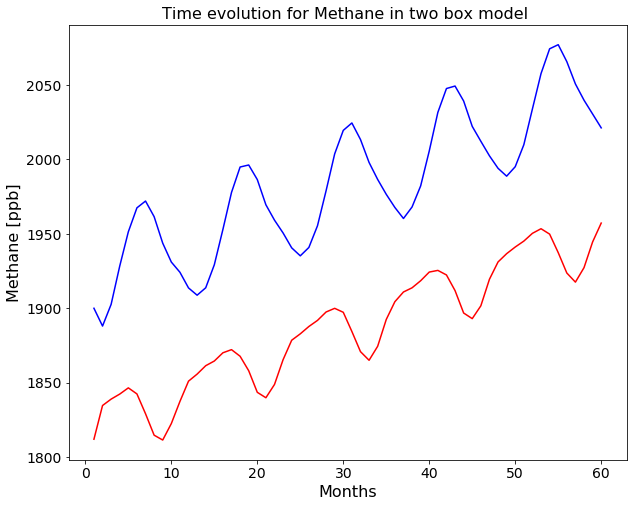

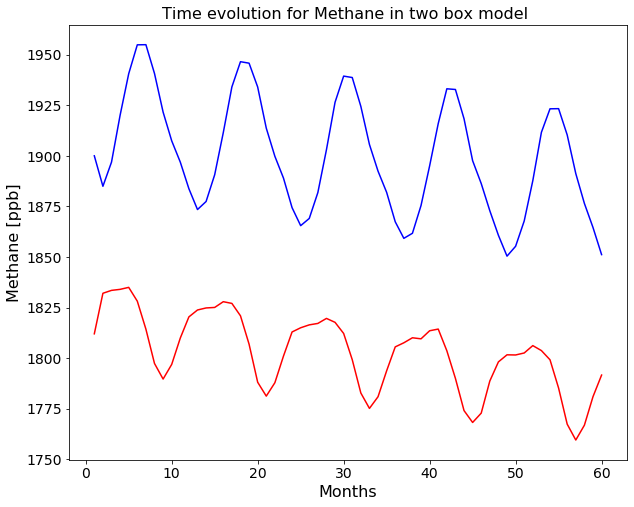

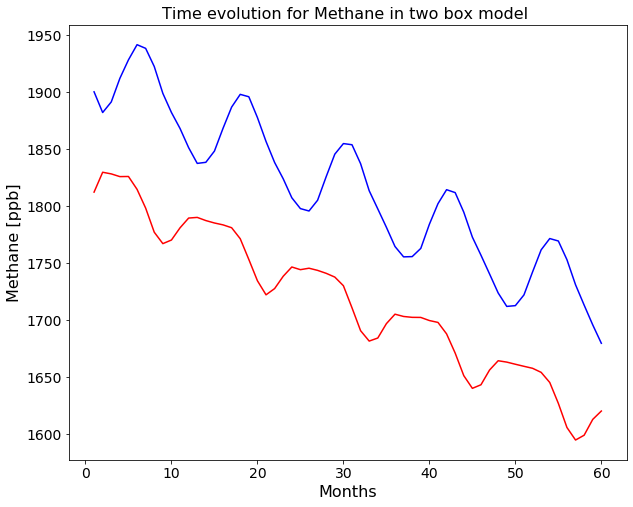

In [10]:
class twobox_tvaryoh():
    """ two box model for methane mass in the atmosphere"""
    
    def __init__(self, mass_atm=5.2e9, mwair=.029, mwch4=.016):
        """ constructor
        
        PARAMETERS:
        
        mass_atm: float
            mass of atmosphere in Tg; converted below to tropospheric mass for consistency with earlier problem
        mwair: float
            molecular weight of dry air in kg/mol
        mwch4: float
            molecular weight of methane in kg/mol
   
        """
        self.mass_atm = mass_atm*.9
        self.mwair = mwair
        self.mwch4 = mwch4
        self.conv = self.mass_atm*1e-9*mwch4/mwair
        return None

    def integrate_tracer(self, name='Methane', emis=5.2e2, nhemisfrac=0.75, nhOH=0., ohperiod=30., ohamp=.15, chem_loss=1./9., tauNS=1.0,
                        concNH_ini=1812., concSH_ini=1900., time_ini=0, run_duration=60, time_offset=1,tstep=1, k=0.01):
        """ time integration of the two box equation`
        
        PARAMETERS:
        
        name: str
            name of the chemical species
        emis: float
            Total global methane emissions to the atmosphere in Tg/y
        nhemisfrac: float
            Fraction of total emissions occurring within the northern hemisphere
        nhOH: float
            Percentage by which to increase the loss rate (due to differences in OH) in NH and decrease in SH
        ohperiod: float
            Period for OH oscillation in years
        ohamp: float
            Amplitude of OH oscillation as percentage
        chem_loss: float
            Total removal rate due to chemical loss from the atmosphere in 1/year 
        tauNS: float
            Exchange rate between northern and southern hemispheres, in years
        concNH_ini: float
            initial concentration of chemical species in ppb in NH
        concSH_ini: float
            initial concentration of cheimcal species in ppb in SH
        time_ini: float
            starting time
        run_duration: float
            integration time in years
        time_offset: float
            time from year 0 at which integration begins 
        tstep: float
            time step for integration in years
        """
        self.name = name
        self.k = k
#         self.emis = emis
        self.emisNH = emis*nhemisfrac
        self.emisSH = emis*(1-nhemisfrac)
        self.tauNS = tauNS
        self.ohperiod = ohperiod
        self.ohamp = ohamp
        #print('CHEM_LOSS=',chem_loss)
#         self.chem_lossNH = chem_loss+(chem_loss*nhOH)
#         self.chem_lossSH = chem_loss-(chem_loss*nhOH)
        #print('N, S, AVGNS = ',self.chem_lossNH, self.chem_lossSH, ((self.chem_lossNH+self.chem_lossSH)/2.))
        self.conc_ini = np.array([concNH_ini,concSH_ini])
        self.mass_ini = self.conc_ini*(self.conv/2.)
        self.time_ini = time_ini
        self.time_end = run_duration
        self.time_offset = time_offset
        self.tstep = np.arange(self.time_end-self.time_ini)/tstep
        
        
        # integrate the box equation with RK45
        # Need vectorized to be true for more than one equation
        solver = spint.solve_ivp(self.methane_twobox_equations, (self.time_ini, self.time_end,),
                                 self.mass_ini, method='RK45', t_eval=self.tstep, vectorized='True')
   
     
        self.time = solver['t']
        #print(self.time)
        self.tracer_mass = solver['y'].squeeze()
        #convert mass back to mixing ratio
        self.tracer_ppb =self.tracer_mass/(self.conv/2.)
        # plot the results
        self.plot_timeserie()
        return self.time, self.tracer_ppb

              
    def plot_timeserie(self):
        """ plotting function """
        plt.figure(figsize=[10,8])
        plt.plot(self.time+self.time_offset, self.tracer_ppb[0], color='red')
        plt.plot(self.time+self.time_offset, self.tracer_ppb[1], color='blue')
        plt.xlabel('Months',fontsize=16)
        plt.ylabel(self.name + ' [ppb]', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Time evolution for ' + self.name + 
                  ' in two box model ', fontsize=16)
        return None
        
    def methane_twobox_equations(self, time_rk45, mass):
        """ governing equation """ 
        # budget adjustment
        budget_adjust_nh = np.array(((ch4_emission_all_nh)*self.conv).mean() - lch4_VMR_nh.mean())
        budget_adjust_sh = np.array(((ch4_emission_all_sh)*self.conv).mean() - lch4_VMR_sh.mean())
        
        # emissions
        E_nh = np.array(ch4_emission_all_nh.sel(time = time_rk45, method='nearest'))
        E_sh = np.array(ch4_emission_all_nh.sel(time = time_rk45, method='nearest'))

        # total CH4 removal
        removal_total_nh = np.array(lch4_VMR_nh.sel(month = time_rk45 % 12, method = 'nearest'))
        removal_total_sh = np.array(lch4_VMR_sh.sel(month = time_rk45 % 12, method = 'nearest'))

        dMnhdt = (E_nh*self.conv - budget_adjust_nh) - self.k * removal_total_nh + ((mass[1]-mass[0])/self.tauNS)
        dMshdt = (E_sh*self.conv - budget_adjust_sh) - self.k * removal_total_sh + ((mass[0]-mass[1])/self.tauNS)
        
        return np.array([dMnhdt, dMshdt])
boxmodel_tvaryoh = twobox_tvaryoh()
t_2b_lch4_2_1, ch4_conc_2b_lch4_2_1 = boxmodel_tvaryoh.integrate_tracer(k = 6.8, tauNS = 1)
t_2b_lch4_2_2, ch4_conc_2b_lch4_2_2 = boxmodel_tvaryoh.integrate_tracer(k = 6.9, tauNS = 1)
t_2b_lch4_2_3, ch4_conc_2b_lch4_2_3 = boxmodel_tvaryoh.integrate_tracer(k = 7.0, tauNS = 1)
t_2b_lch4_2_4, ch4_conc_2b_lch4_2_4 = boxmodel_tvaryoh.integrate_tracer(k = 7.1, tauNS = 1)

t_2b_lch4_2_11, ch4_conc_2b_lch4_2_11 = boxmodel_tvaryoh.integrate_tracer(k = 6.8, tauNS = 0.5)
t_2b_lch4_2_21, ch4_conc_2b_lch4_2_21 = boxmodel_tvaryoh.integrate_tracer(k = 6.9, tauNS = 0.5)
t_2b_lch4_2_31, ch4_conc_2b_lch4_2_31 = boxmodel_tvaryoh.integrate_tracer(k = 7.0, tauNS = 0.5)
t_2b_lch4_2_41, ch4_conc_2b_lch4_2_41 = boxmodel_tvaryoh.integrate_tracer(k = 7.1, tauNS = 0.5)

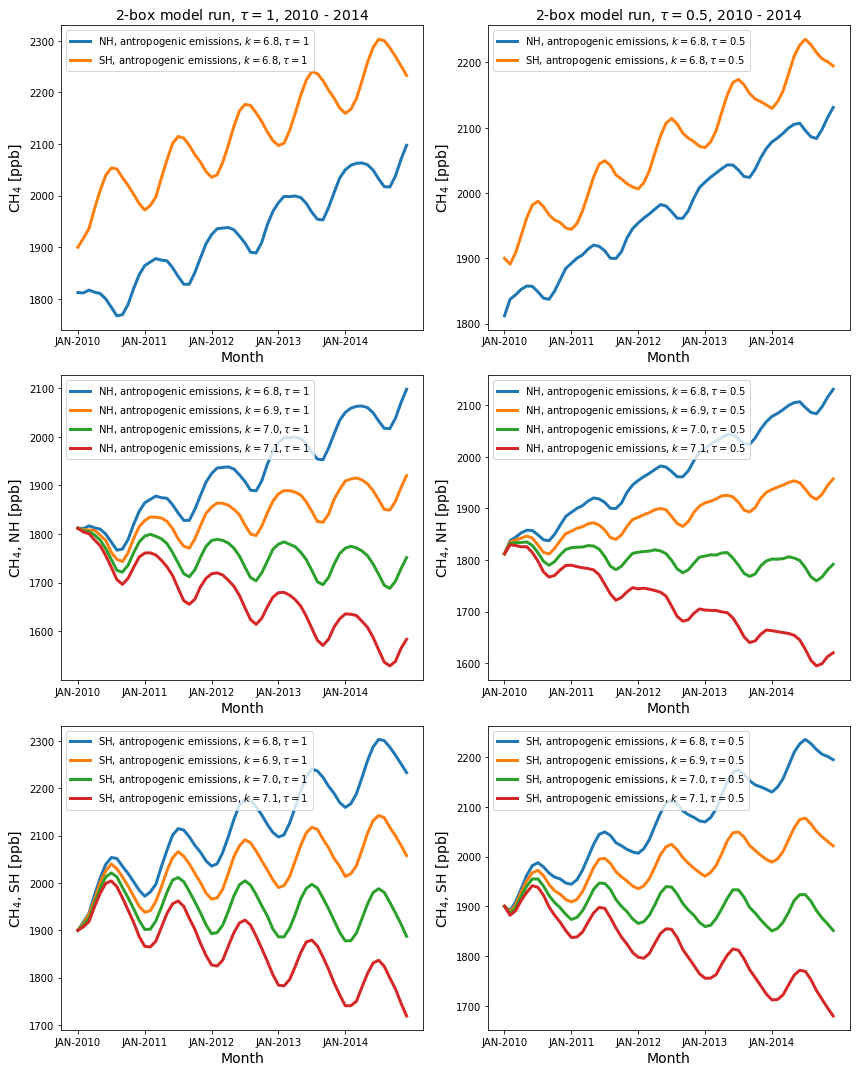

In [11]:
fig = plt.figure(figsize=[6,5])
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 3)

ax = fig.add_subplot(3,2,1)
plt.plot(ch4_conc_2b_lch4_2_1[0], linewidth=3, label=r'NH, antropogenic emissions, $k=6.8, \tau=1$')
plt.plot(ch4_conc_2b_lch4_2_1[1], linewidth=3, label=r'SH, antropogenic emissions, $k=6.8,\tau=1$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, $\tau = 1$, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(3,2,2)
plt.plot(ch4_conc_2b_lch4_2_11[0], linewidth=3, label=r'NH, antropogenic emissions, $k=6.8, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_2_11[1], linewidth=3, label=r'SH, antropogenic emissions, $k=6.8,\tau=0.5$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, $\tau = 0.5$, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(3,2,3)
plt.plot(ch4_conc_2b_lch4_2_1[0], linewidth=3, label=r'NH, antropogenic emissions, $k=6.8, \tau=1$')
plt.plot(ch4_conc_2b_lch4_2_2[0], linewidth=3, label=r'NH, antropogenic emissions, $k=6.9, \tau=1$')
plt.plot(ch4_conc_2b_lch4_2_3[0], linewidth=3, label=r'NH, antropogenic emissions, $k=7.0, \tau=1$')
plt.plot(ch4_conc_2b_lch4_2_4[0], linewidth=3, label=r'NH, antropogenic emissions, $k=7.1, \tau=1$')
plt.ylabel('CH$_4$, NH [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
# plt.title('2-box model run, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(3,2,4)
plt.plot(ch4_conc_2b_lch4_2_11[0], linewidth=3, label=r'NH, antropogenic emissions, $k=6.8, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_2_21[0], linewidth=3, label=r'NH, antropogenic emissions, $k=6.9, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_2_31[0], linewidth=3, label=r'NH, antropogenic emissions, $k=7.0, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_2_41[0], linewidth=3, label=r'NH, antropogenic emissions, $k=7.1, \tau=0.5$')
plt.ylabel('CH$_4$, NH [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
# plt.title('2-box model run, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(3,2,5)
plt.plot(ch4_conc_2b_lch4_2_1[1], linewidth=3, label=r'SH, antropogenic emissions, $k=6.8, \tau=1$')
plt.plot(ch4_conc_2b_lch4_2_2[1], linewidth=3, label=r'SH, antropogenic emissions, $k=6.9, \tau=1$')
plt.plot(ch4_conc_2b_lch4_2_3[1], linewidth=3, label=r'SH, antropogenic emissions, $k=7.0, \tau=1$')
plt.plot(ch4_conc_2b_lch4_2_4[1], linewidth=3, label=r'SH, antropogenic emissions, $k=7.1, \tau=1$')
plt.ylabel('CH$_4$, SH [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
# plt.title('2-box model run, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(3,2,6)
plt.plot(ch4_conc_2b_lch4_2_11[1], linewidth=3, label=r'SH, antropogenic emissions, $k=6.8, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_2_21[1], linewidth=3, label=r'SH, antropogenic emissions, $k=6.9, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_2_31[1], linewidth=3, label=r'SH, antropogenic emissions, $k=7.0, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_2_41[1], linewidth=3, label=r'SH, antropogenic emissions, $k=7.1, \tau=0.5$')
plt.ylabel('CH$_4$, SH [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
# plt.title('2-box model run, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

plt.tight_layout()
plt.savefig('figures/2_box_LCH4_5_year_timeseries_all_cases_antropogenic_only.pdf')

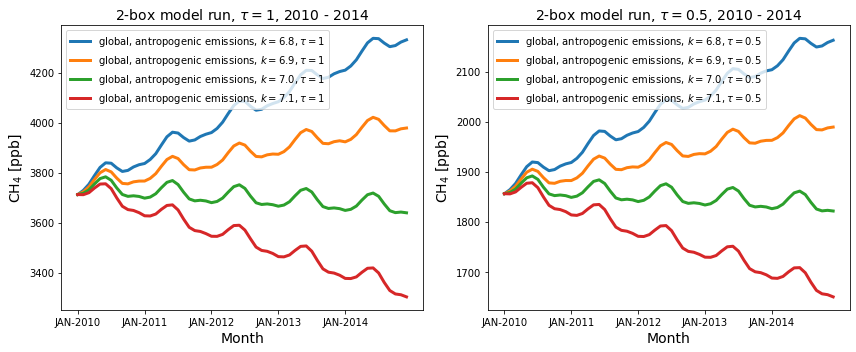

In [41]:
fig = plt.figure(figsize=[6,5])
fig.set_figwidth(fig.get_figwidth() * 2)
# fig.set_figheight(fig.get_figheight() * 3)

ax = fig.add_subplot(1,2,1)
plt.plot(ch4_conc_2b_lch4_2_1[0] + ch4_conc_2b_lch4_2_1[1], linewidth=3, label=r'global, antropogenic emissions, $k=6.8, \tau=1$')
plt.plot(ch4_conc_2b_lch4_2_2[0] + ch4_conc_2b_lch4_2_2[1], linewidth=3, label=r'global, antropogenic emissions, $k=6.9, \tau=1$')
plt.plot(ch4_conc_2b_lch4_2_3[0] + ch4_conc_2b_lch4_2_3[1], linewidth=3, label=r'global, antropogenic emissions, $k=7.0, \tau=1$')
plt.plot(ch4_conc_2b_lch4_2_4[0] + ch4_conc_2b_lch4_2_4[1], linewidth=3, label=r'global, antropogenic emissions, $k=7.1, \tau=1$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, $\tau = 1$, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(1,2,2)
plt.plot((ch4_conc_2b_lch4_2_11[0] + ch4_conc_2b_lch4_2_11[1])/2, linewidth=3, label=r'global, antropogenic emissions, $k=6.8, \tau=0.5$')
plt.plot((ch4_conc_2b_lch4_2_21[0] + ch4_conc_2b_lch4_2_21[1])/2, linewidth=3, label=r'global, antropogenic emissions, $k=6.9, \tau=0.5$')
plt.plot((ch4_conc_2b_lch4_2_31[0] + ch4_conc_2b_lch4_2_31[1])/2, linewidth=3, label=r'global, antropogenic emissions, $k=7.0, \tau=0.5$')
plt.plot((ch4_conc_2b_lch4_2_41[0] + ch4_conc_2b_lch4_2_41[1])/2, linewidth=3, label=r'global, antropogenic emissions, $k=7.1, \tau=0.5$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, $\tau = 0.5$, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

plt.tight_layout()
plt.savefig('figures/2_box_LCH4_5_year_timeseries_antropogenic_only.pdf')

In [13]:
# tau = 1
mean_monthly_nh_2_1 = (ch4_conc_2b_lch4_2_1[0][:12] + ch4_conc_2b_lch4_2_1[0][12:24] + ch4_conc_2b_lch4_2_1[0][24:36]\
               + ch4_conc_2b_lch4_2_1[0][36:48] + ch4_conc_2b_lch4_2_1[0][48:])/5
mean_monthly_sh_2_1 = (ch4_conc_2b_lch4_2_1[1][:12] + ch4_conc_2b_lch4_2_1[1][12:24] + ch4_conc_2b_lch4_2_1[1][24:36]\
               + ch4_conc_2b_lch4_2_1[1][36:48] + ch4_conc_2b_lch4_2_1[1][48:])/5
mean_monthly_global_2_1 = (mean_monthly_nh_2_1 + mean_monthly_sh_2_1) / 2


mean_monthly_nh_2_2 = (ch4_conc_2b_lch4_2_2[0][:12] + ch4_conc_2b_lch4_2_2[0][12:24] + ch4_conc_2b_lch4_2_2[0][24:36]\
               + ch4_conc_2b_lch4_2_2[0][36:48] + ch4_conc_2b_lch4_2_2[0][48:])/5
mean_monthly_sh_2_2 = (ch4_conc_2b_lch4_2_2[1][:12] + ch4_conc_2b_lch4_2_2[1][12:24] + ch4_conc_2b_lch4_2_2[1][24:36]\
               + ch4_conc_2b_lch4_2_2[1][36:48] + ch4_conc_2b_lch4_2_2[1][48:])/5
mean_monthly_global_2_2 = (mean_monthly_nh_2_2 + mean_monthly_sh_2_2) / 2 


mean_monthly_nh_2_3 = (ch4_conc_2b_lch4_2_3[0][:12] + ch4_conc_2b_lch4_2_3[0][12:24] + ch4_conc_2b_lch4_2_3[0][24:36]\
               + ch4_conc_2b_lch4_2_3[0][36:48] + ch4_conc_2b_lch4_2_3[0][48:])/5
mean_monthly_sh_2_3 = (ch4_conc_2b_lch4_2_3[1][:12] + ch4_conc_2b_lch4_2_3[1][12:24] + ch4_conc_2b_lch4_2_3[1][24:36]\
               + ch4_conc_2b_lch4_2_3[1][36:48] + ch4_conc_2b_lch4_2_3[1][48:])/5
mean_monthly_global_2_3 = (mean_monthly_nh_2_3 + mean_monthly_sh_2_3) / 2 


mean_monthly_nh_2_4 = (ch4_conc_2b_lch4_2_4[0][:12] + ch4_conc_2b_lch4_2_4[0][12:24] + ch4_conc_2b_lch4_2_4[0][24:36]\
               + ch4_conc_2b_lch4_2_4[0][36:48] + ch4_conc_2b_lch4_2_4[0][48:])/5
mean_monthly_sh_2_4 = (ch4_conc_2b_lch4_2_4[1][:12] + ch4_conc_2b_lch4_2_4[1][12:24] + ch4_conc_2b_lch4_2_4[1][24:36]\
               + ch4_conc_2b_lch4_2_4[1][36:48] + ch4_conc_2b_lch4_2_4[1][48:])/5
mean_monthly_global_2_4 = (mean_monthly_nh_2_4 + mean_monthly_sh_2_4) / 2

# tau = 0.5 
mean_monthly_nh_2_11 = (ch4_conc_2b_lch4_2_11[0][:12] + ch4_conc_2b_lch4_2_11[0][12:24] + ch4_conc_2b_lch4_2_11[0][24:36]\
               + ch4_conc_2b_lch4_2_11[0][36:48] + ch4_conc_2b_lch4_2_11[0][48:])/5
mean_monthly_sh_2_11 = (ch4_conc_2b_lch4_2_11[1][:12] + ch4_conc_2b_lch4_2_11[1][12:24] + ch4_conc_2b_lch4_2_11[1][24:36]\
               + ch4_conc_2b_lch4_2_11[1][36:48] + ch4_conc_2b_lch4_2_11[1][48:])/5
mean_monthly_global_2_11 = (mean_monthly_nh_2_11 + mean_monthly_sh_2_11) / 2 


mean_monthly_nh_2_21 = (ch4_conc_2b_lch4_2_21[0][:12] + ch4_conc_2b_lch4_2_21[0][12:24] + ch4_conc_2b_lch4_2_21[0][24:36]\
               + ch4_conc_2b_lch4_2_21[0][36:48] + ch4_conc_2b_lch4_2_21[0][48:])/5
mean_monthly_sh_2_21 = (ch4_conc_2b_lch4_2_21[1][:12] + ch4_conc_2b_lch4_2_21[1][12:24] + ch4_conc_2b_lch4_2_21[1][24:36]\
               + ch4_conc_2b_lch4_2_21[1][36:48] + ch4_conc_2b_lch4_2_21[1][48:])/5
mean_monthly_global_2_21 = (mean_monthly_nh_2_21 + mean_monthly_sh_2_21) / 2 


mean_monthly_nh_2_31 = (ch4_conc_2b_lch4_2_31[0][:12] + ch4_conc_2b_lch4_2_31[0][12:24] + ch4_conc_2b_lch4_2_31[0][24:36]\
               + ch4_conc_2b_lch4_2_31[0][36:48] + ch4_conc_2b_lch4_2_31[0][48:])/5
mean_monthly_sh_2_31 = (ch4_conc_2b_lch4_2_31[1][:12] + ch4_conc_2b_lch4_2_31[1][12:24] + ch4_conc_2b_lch4_2_31[1][24:36]\
               + ch4_conc_2b_lch4_2_31[1][36:48] + ch4_conc_2b_lch4_2_31[1][48:])/5
mean_monthly_global_2_31 = (mean_monthly_nh_2_31 + mean_monthly_sh_2_31) / 2 


mean_monthly_nh_2_41 = (ch4_conc_2b_lch4_2_41[0][:12] + ch4_conc_2b_lch4_2_41[0][12:24] + ch4_conc_2b_lch4_2_41[0][24:36]\
               + ch4_conc_2b_lch4_2_41[0][36:48] + ch4_conc_2b_lch4_2_41[0][48:])/5
mean_monthly_sh_2_41 = (ch4_conc_2b_lch4_2_41[1][:12] + ch4_conc_2b_lch4_2_41[1][12:24] + ch4_conc_2b_lch4_2_41[1][24:36]\
               + ch4_conc_2b_lch4_2_41[1][36:48] + ch4_conc_2b_lch4_2_41[1][48:])/5
mean_monthly_global_2_41 = (mean_monthly_nh_2_41 + mean_monthly_sh_2_41) / 2

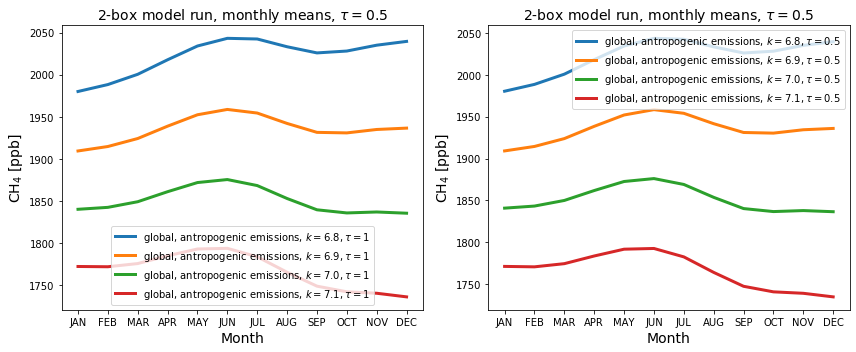

In [14]:

fig = plt.figure(figsize=[6,5])
fig.set_figwidth(fig.get_figwidth() * 2)
# fig.set_figheight(fig.get_figheight() * 2)

ax = fig.add_subplot(1,2,1)
plt.plot(mean_monthly_global_2_1, linewidth=3, label=r'global, antropogenic emissions, $k=6.8, \tau=1$')
plt.plot(mean_monthly_global_2_2, linewidth=3, label=r'global, antropogenic emissions, $k=6.9, \tau=1$')
plt.plot(mean_monthly_global_2_3, linewidth=3, label=r'global, antropogenic emissions, $k=7.0, \tau=1$')
plt.plot(mean_monthly_global_2_4, linewidth=3, label=r'global, antropogenic emissions, $k=7.1, \tau=1$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, monthly means, $\tau = 0.5$', fontsize=14)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], months)
plt.tight_layout()

ax = fig.add_subplot(1,2,2)
plt.plot(mean_monthly_global_2_11, linewidth=3, label=r'global, antropogenic emissions, $k=6.8, \tau=0.5$')
plt.plot(mean_monthly_global_2_21, linewidth=3, label=r'global, antropogenic emissions, $k=6.9, \tau=0.5$')
plt.plot(mean_monthly_global_2_31, linewidth=3, label=r'global, antropogenic emissions, $k=7.0, \tau=0.5$')
plt.plot(mean_monthly_global_2_41, linewidth=3, label=r'global, antropogenic emissions, $k=7.1, \tau=0.5$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, monthly means, $\tau = 0.5$', fontsize=14)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], months)
plt.tight_layout()

plt.tight_layout()
plt.savefig('figures/2_box_LCH4_5_year_monthly_means_antropogenic_only.pdf')

## 2-box model with with Wetland emission only 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/integrate/_ivp/rk.py:144: RuntimeWarning: invalid value encountered in maximum
  scale = atol + np.maximum(np.abs(y), np.abs(y_new)) * rtol


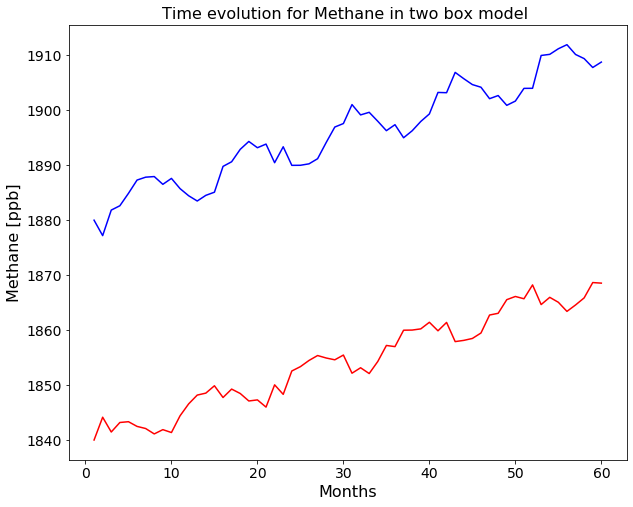

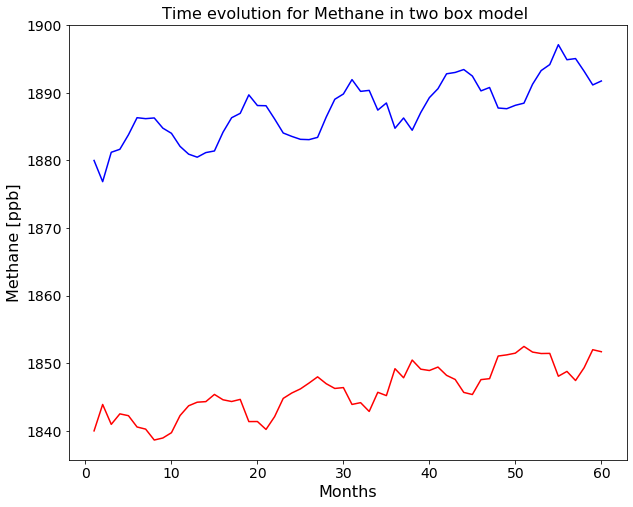

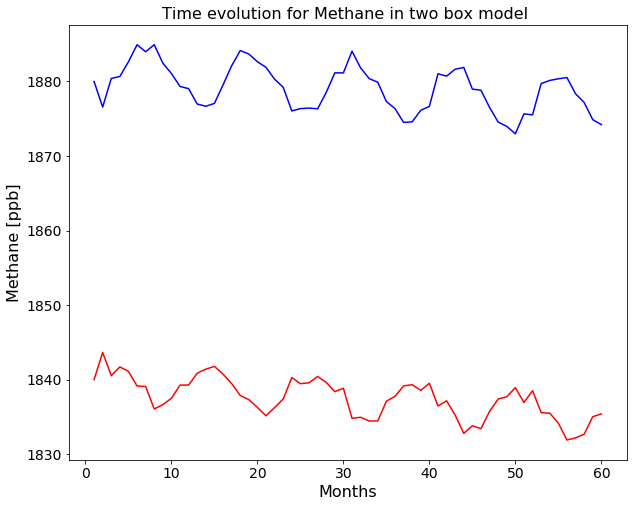

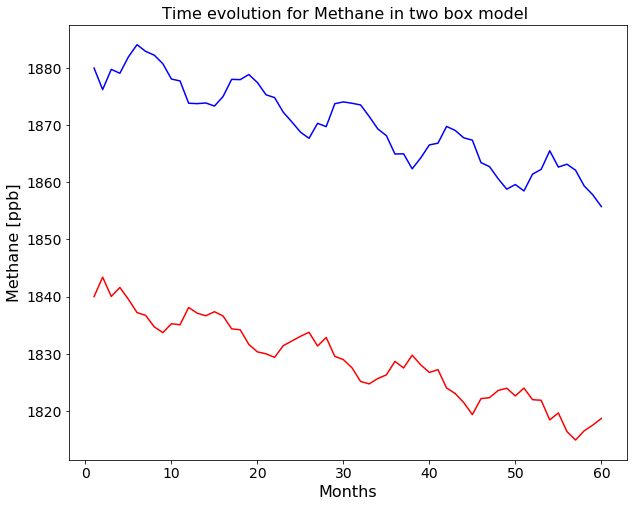

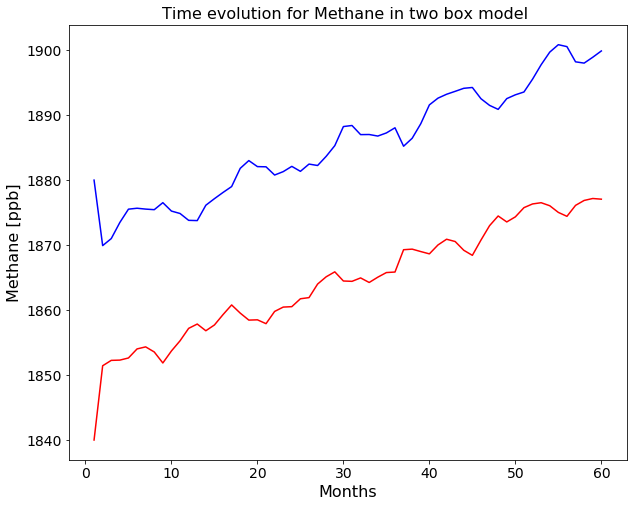

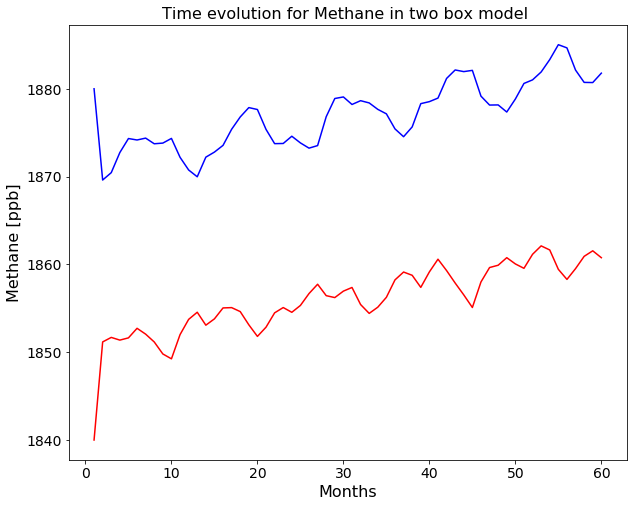

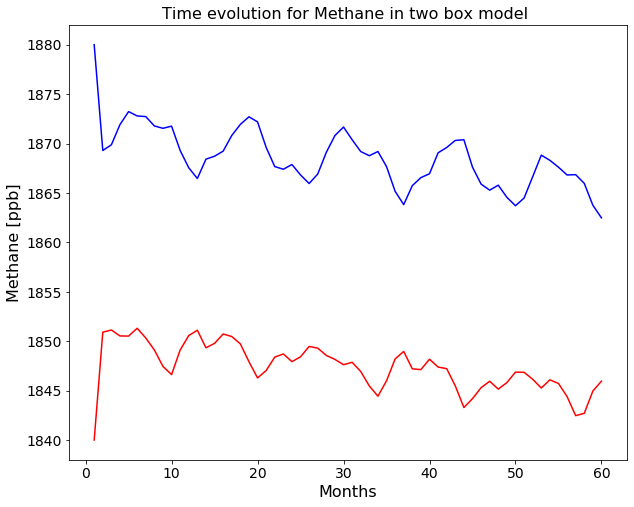

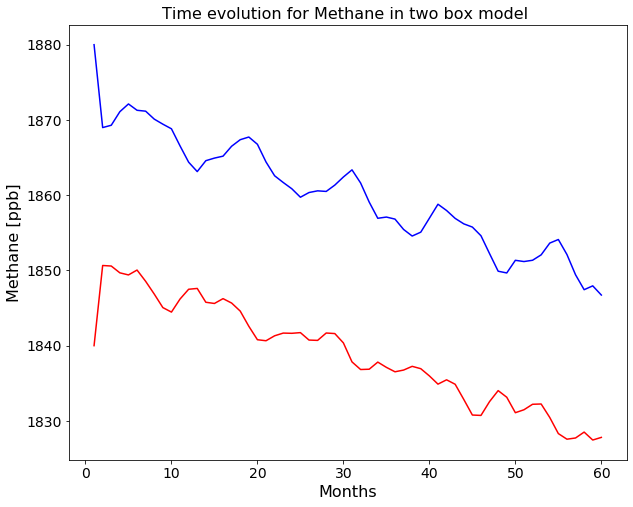

In [45]:
class twobox_tvaryoh():
    """ two box model for methane mass in the atmosphere"""
    
    def __init__(self, mass_atm=5.2e9, mwair=.029, mwch4=.016):
        """ constructor
        
        PARAMETERS:
        
        mass_atm: float
            mass of atmosphere in Tg; converted below to tropospheric mass for consistency with earlier problem
        mwair: float
            molecular weight of dry air in kg/mol
        mwch4: float
            molecular weight of methane in kg/mol
   
        """
        self.mass_atm = mass_atm*.9
        self.mwair = mwair
        self.mwch4 = mwch4
        self.conv = self.mass_atm*1e-9*mwch4/mwair
        return None

    def integrate_tracer(self, name='Methane', emis=5.2e2, nhemisfrac=0.75, nhOH=0., ohperiod=30., ohamp=.15, chem_loss=1./9., tauNS=1.0,
                        concNH_ini=1840., concSH_ini=1880., time_ini=0, run_duration=60, time_offset=1,tstep=1, k=0.01):
        """ time integration of the two box equation`
        
        PARAMETERS:
        
        name: str
            name of the chemical species
        emis: float
            Total global methane emissions to the atmosphere in Tg/y
        nhemisfrac: float
            Fraction of total emissions occurring within the northern hemisphere
        nhOH: float
            Percentage by which to increase the loss rate (due to differences in OH) in NH and decrease in SH
        ohperiod: float
            Period for OH oscillation in years
        ohamp: float
            Amplitude of OH oscillation as percentage
        chem_loss: float
            Total removal rate due to chemical loss from the atmosphere in 1/year 
        tauNS: float
            Exchange rate between northern and southern hemispheres, in years
        concNH_ini: float
            initial concentration of chemical species in ppb in NH
        concSH_ini: float
            initial concentration of cheimcal species in ppb in SH
        time_ini: float
            starting time
        run_duration: float
            integration time in years
        time_offset: float
            time from year 0 at which integration begins 
        tstep: float
            time step for integration in years
        """
        self.name = name
        self.k = k
#         self.emis = emis
        self.emisNH = emis*nhemisfrac
        self.emisSH = emis*(1-nhemisfrac)
        self.tauNS = tauNS
        self.ohperiod = ohperiod
        self.ohamp = ohamp
        #print('CHEM_LOSS=',chem_loss)
#         self.chem_lossNH = chem_loss+(chem_loss*nhOH)
#         self.chem_lossSH = chem_loss-(chem_loss*nhOH)
        #print('N, S, AVGNS = ',self.chem_lossNH, self.chem_lossSH, ((self.chem_lossNH+self.chem_lossSH)/2.))
        self.conc_ini = np.array([concNH_ini,concSH_ini])
        self.mass_ini = self.conc_ini*(self.conv/2.)
        self.time_ini = time_ini
        self.time_end = run_duration
        self.time_offset = time_offset
        self.tstep = np.arange(self.time_end-self.time_ini)/tstep
        
        
        # integrate the box equation with RK45
        # Need vectorized to be true for more than one equation
        solver = spint.solve_ivp(self.methane_twobox_equations, (self.time_ini, self.time_end,),
                                 self.mass_ini, method='RK45', t_eval=self.tstep, vectorized='True')
   
     
        self.time = solver['t']
        #print(self.time)
        self.tracer_mass = solver['y'].squeeze()
        #convert mass back to mixing ratio
        self.tracer_ppb =self.tracer_mass/(self.conv/2.)
        # plot the results
        self.plot_timeserie()
        return self.time, self.tracer_ppb

              
    def plot_timeserie(self):
        """ plotting function """
        plt.figure(figsize=[10,8])
        plt.plot(self.time+self.time_offset, self.tracer_ppb[0], color='red')
        plt.plot(self.time+self.time_offset, self.tracer_ppb[1], color='blue')
        plt.xlabel('Months',fontsize=16)
        plt.ylabel(self.name + ' [ppb]', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.title('Time evolution for ' + self.name + 
                  ' in two box model ', fontsize=16)
        return None
        
    def methane_twobox_equations(self, time_rk45, mass):
        """ governing equation """ 
        # budget adjustment
        budget_adjust_nh = np.array(((wet_emission_all_nh)*self.conv).mean() - lch4_VMR_nh.mean())
        budget_adjust_sh = np.array(((wet_emission_all_sh)*self.conv).mean() - lch4_VMR_sh.mean())
        
        # emissions
        E_nh = np.array(wet_emission_all_nh.sel(time = time_rk45, method='nearest'))
        E_sh = np.array(wet_emission_all_sh.sel(time = time_rk45, method='nearest'))

        # total CH4 removal
        removal_total_nh = np.array(lch4_VMR_nh.sel(month = time_rk45 % 12, method = 'nearest'))
        removal_total_sh = np.array(lch4_VMR_sh.sel(month = time_rk45 % 12, method = 'nearest'))

        dMnhdt = (E_nh*self.conv - budget_adjust_nh) - self.k * removal_total_nh + ((mass[1]-mass[0])/self.tauNS)
        dMshdt = (E_sh*self.conv - budget_adjust_sh) - self.k * removal_total_sh + ((mass[0]-mass[1])/self.tauNS)
        
        return np.array([dMnhdt, dMshdt])
boxmodel_tvaryoh = twobox_tvaryoh()
t_2b_lch4_3_1, ch4_conc_2b_lch4_3_1 = boxmodel_tvaryoh.integrate_tracer(k = 0.44, tauNS = 1)
t_2b_lch4_3_2, ch4_conc_2b_lch4_3_2 = boxmodel_tvaryoh.integrate_tracer(k = 0.45, tauNS = 1)
t_2b_lch4_3_3, ch4_conc_2b_lch4_3_3 = boxmodel_tvaryoh.integrate_tracer(k = 0.46, tauNS = 1)
t_2b_lch4_3_4, ch4_conc_2b_lch4_3_4 = boxmodel_tvaryoh.integrate_tracer(k = 0.47, tauNS = 1)

t_2b_lch4_3_11, ch4_conc_2b_lch4_3_11 = boxmodel_tvaryoh.integrate_tracer(k = 0.44, tauNS = 0.5)
t_2b_lch4_3_21, ch4_conc_2b_lch4_3_21 = boxmodel_tvaryoh.integrate_tracer(k = 0.45, tauNS = 0.5)
t_2b_lch4_3_31, ch4_conc_2b_lch4_3_31 = boxmodel_tvaryoh.integrate_tracer(k = 0.46, tauNS = 0.5)
t_2b_lch4_3_41, ch4_conc_2b_lch4_3_41 = boxmodel_tvaryoh.integrate_tracer(k = 0.47, tauNS = 0.5)

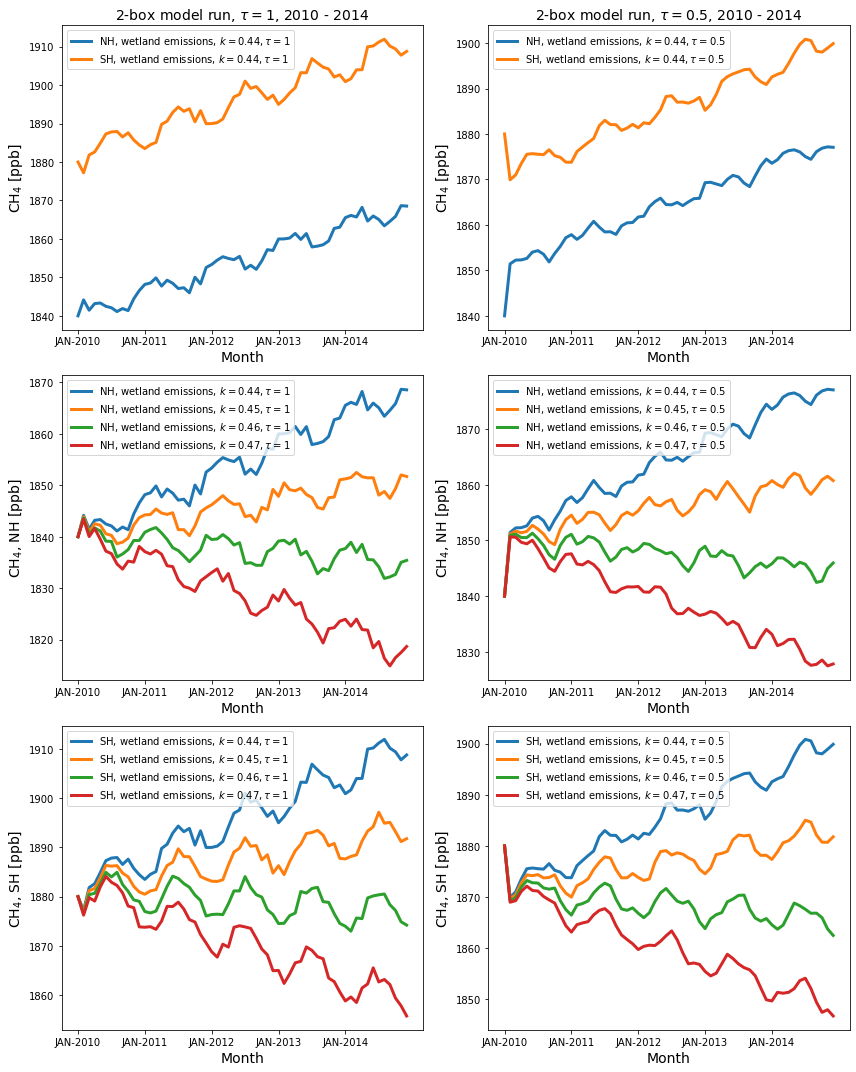

In [46]:
fig = plt.figure(figsize=[6,5])
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 3)

ax = fig.add_subplot(3,2,1)
plt.plot(ch4_conc_2b_lch4_3_1[0], linewidth=3, label=r'NH, wetland emissions, $k=0.44, \tau=1$')
plt.plot(ch4_conc_2b_lch4_3_1[1], linewidth=3, label=r'SH, wetland emissions, $k=0.44,\tau=1$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, $\tau = 1$, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(3,2,2)
plt.plot(ch4_conc_2b_lch4_3_11[0], linewidth=3, label=r'NH, wetland emissions, $k=0.44, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_3_11[1], linewidth=3, label=r'SH, wetland emissions, $k=0.44,\tau=0.5$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, $\tau = 0.5$, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(3,2,3)
plt.plot(ch4_conc_2b_lch4_3_1[0], linewidth=3, label=r'NH, wetland emissions, $k=0.44, \tau=1$')
plt.plot(ch4_conc_2b_lch4_3_2[0], linewidth=3, label=r'NH, wetland emissions, $k=0.45, \tau=1$')
plt.plot(ch4_conc_2b_lch4_3_3[0], linewidth=3, label=r'NH, wetland emissions, $k=0.46, \tau=1$')
plt.plot(ch4_conc_2b_lch4_3_4[0], linewidth=3, label=r'NH, wetland emissions, $k=0.47, \tau=1$')
plt.ylabel('CH$_4$, NH [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
# plt.title('2-box model run, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(3,2,4)
plt.plot(ch4_conc_2b_lch4_3_11[0], linewidth=3, label=r'NH, wetland emissions, $k=0.44, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_3_21[0], linewidth=3, label=r'NH, wetland emissions, $k=0.45, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_3_31[0], linewidth=3, label=r'NH, wetland emissions, $k=0.46, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_3_41[0], linewidth=3, label=r'NH, wetland emissions, $k=0.47, \tau=0.5$')
plt.ylabel('CH$_4$, NH [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
# plt.title('2-box model run, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(3,2,5)
plt.plot(ch4_conc_2b_lch4_3_1[1], linewidth=3, label=r'SH, wetland emissions, $k=0.44, \tau=1$')
plt.plot(ch4_conc_2b_lch4_3_2[1], linewidth=3, label=r'SH, wetland emissions, $k=0.45, \tau=1$')
plt.plot(ch4_conc_2b_lch4_3_3[1], linewidth=3, label=r'SH, wetland emissions, $k=0.46, \tau=1$')
plt.plot(ch4_conc_2b_lch4_3_4[1], linewidth=3, label=r'SH, wetland emissions, $k=0.47, \tau=1$')
plt.ylabel('CH$_4$, SH [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
# plt.title('2-box model run, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(3,2,6)
plt.plot(ch4_conc_2b_lch4_3_11[1], linewidth=3, label=r'SH, wetland emissions, $k=0.44, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_3_21[1], linewidth=3, label=r'SH, wetland emissions, $k=0.45, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_3_31[1], linewidth=3, label=r'SH, wetland emissions, $k=0.46, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_3_41[1], linewidth=3, label=r'SH, wetland emissions, $k=0.47, \tau=0.5$')
plt.ylabel('CH$_4$, SH [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
# plt.title('2-box model run, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

plt.tight_layout()
plt.savefig('figures/2_box_LCH4_5_year_timeseries_all_cases_wetland_only.pdf')

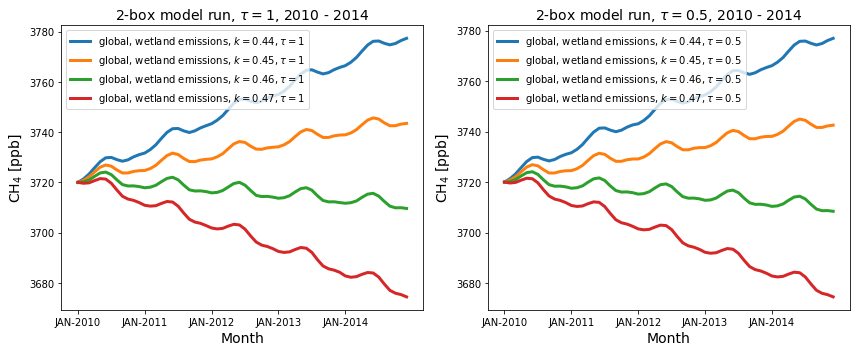

In [47]:
fig = plt.figure(figsize=[6,5])
fig.set_figwidth(fig.get_figwidth() * 2)
# fig.set_figheight(fig.get_figheight() * 3)

ax = fig.add_subplot(1,2,1)
plt.plot(ch4_conc_2b_lch4_3_1[0] + ch4_conc_2b_lch4_3_1[1], linewidth=3, label=r'global, wetland emissions, $k=0.44, \tau=1$')
plt.plot(ch4_conc_2b_lch4_3_2[0] + ch4_conc_2b_lch4_3_2[1], linewidth=3, label=r'global, wetland emissions, $k=0.45, \tau=1$')
plt.plot(ch4_conc_2b_lch4_3_3[0] + ch4_conc_2b_lch4_3_3[1], linewidth=3, label=r'global, wetland emissions, $k=0.46, \tau=1$')
plt.plot(ch4_conc_2b_lch4_3_4[0] + ch4_conc_2b_lch4_3_4[1], linewidth=3, label=r'global, wetland emissions, $k=0.47, \tau=1$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, $\tau = 1$, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

ax = fig.add_subplot(1,2,2)
plt.plot(ch4_conc_2b_lch4_3_11[0] + ch4_conc_2b_lch4_3_11[1], linewidth=3, label=r'global, wetland emissions, $k=0.44, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_3_21[0] + ch4_conc_2b_lch4_3_21[1], linewidth=3, label=r'global, wetland emissions, $k=0.45, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_3_31[0] + ch4_conc_2b_lch4_3_31[1], linewidth=3, label=r'global, wetland emissions, $k=0.46, \tau=0.5$')
plt.plot(ch4_conc_2b_lch4_3_41[0] + ch4_conc_2b_lch4_3_41[1], linewidth=3, label=r'global, wetland emissions, $k=0.47, \tau=0.5$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, $\tau = 0.5$, 2010 - 2014', fontsize=14)
plt.xticks([0,12,24,36,48], ['JAN-2010','JAN-2011','JAN-2012','JAN-2013','JAN-2014'])
plt.tight_layout()

plt.tight_layout()
plt.savefig('figures/2_box_LCH4_5_year_timeseries_wetland_only.pdf')

In [48]:
# tau = 1
mean_monthly_nh_3_1 = (ch4_conc_2b_lch4_3_1[0][:12] + ch4_conc_2b_lch4_3_1[0][12:24] + ch4_conc_2b_lch4_3_1[0][24:36]\
               + ch4_conc_2b_lch4_3_1[0][36:48] + ch4_conc_2b_lch4_3_1[0][48:])/5
mean_monthly_sh_3_1 = (ch4_conc_2b_lch4_3_1[1][:12] + ch4_conc_2b_lch4_3_1[1][12:24] + ch4_conc_2b_lch4_3_1[1][24:36]\
               + ch4_conc_2b_lch4_3_1[1][36:48] + ch4_conc_2b_lch4_3_1[1][48:])/5
mean_monthly_global_3_1 = (mean_monthly_nh_3_1 + mean_monthly_sh_3_1) / 2


mean_monthly_nh_3_2 = (ch4_conc_2b_lch4_3_2[0][:12] + ch4_conc_2b_lch4_3_2[0][12:24] + ch4_conc_2b_lch4_3_2[0][24:36]\
               + ch4_conc_2b_lch4_3_2[0][36:48] + ch4_conc_2b_lch4_3_2[0][48:])/5
mean_monthly_sh_3_2 = (ch4_conc_2b_lch4_3_2[1][:12] + ch4_conc_2b_lch4_3_2[1][12:24] + ch4_conc_2b_lch4_3_2[1][24:36]\
               + ch4_conc_2b_lch4_3_2[1][36:48] + ch4_conc_2b_lch4_3_2[1][48:])/5
mean_monthly_global_3_2 = (mean_monthly_nh_3_2 + mean_monthly_sh_3_2) / 2 


mean_monthly_nh_3_3 = (ch4_conc_2b_lch4_3_3[0][:12] + ch4_conc_2b_lch4_3_3[0][12:24] + ch4_conc_2b_lch4_3_3[0][24:36]\
               + ch4_conc_2b_lch4_3_3[0][36:48] + ch4_conc_2b_lch4_3_3[0][48:])/5
mean_monthly_sh_3_3 = (ch4_conc_2b_lch4_3_3[1][:12] + ch4_conc_2b_lch4_3_3[1][12:24] + ch4_conc_2b_lch4_3_3[1][24:36]\
               + ch4_conc_2b_lch4_3_3[1][36:48] + ch4_conc_2b_lch4_3_3[1][48:])/5
mean_monthly_global_3_3 = (mean_monthly_nh_3_3 + mean_monthly_sh_3_3) / 2 


mean_monthly_nh_3_4 = (ch4_conc_2b_lch4_3_4[0][:12] + ch4_conc_2b_lch4_3_4[0][12:24] + ch4_conc_2b_lch4_3_4[0][24:36]\
               + ch4_conc_2b_lch4_3_4[0][36:48] + ch4_conc_2b_lch4_3_4[0][48:])/5
mean_monthly_sh_3_4 = (ch4_conc_2b_lch4_3_4[1][:12] + ch4_conc_2b_lch4_3_4[1][12:24] + ch4_conc_2b_lch4_3_4[1][24:36]\
               + ch4_conc_2b_lch4_3_4[1][36:48] + ch4_conc_2b_lch4_3_4[1][48:])/5
mean_monthly_global_3_4 = (mean_monthly_nh_3_4 + mean_monthly_sh_3_4) / 2

# tau = 0.5 
mean_monthly_nh_3_11 = (ch4_conc_2b_lch4_3_11[0][:12] + ch4_conc_2b_lch4_3_11[0][12:24] + ch4_conc_2b_lch4_3_11[0][24:36]\
               + ch4_conc_2b_lch4_3_11[0][36:48] + ch4_conc_2b_lch4_3_11[0][48:])/5
mean_monthly_sh_3_11 = (ch4_conc_2b_lch4_3_11[1][:12] + ch4_conc_2b_lch4_3_11[1][12:24] + ch4_conc_2b_lch4_3_11[1][24:36]\
               + ch4_conc_2b_lch4_3_11[1][36:48] + ch4_conc_2b_lch4_3_11[1][48:])/5
mean_monthly_global_3_11 = (mean_monthly_nh_3_11 + mean_monthly_sh_3_11) / 2 


mean_monthly_nh_3_21 = (ch4_conc_2b_lch4_3_21[0][:12] + ch4_conc_2b_lch4_3_21[0][12:24] + ch4_conc_2b_lch4_3_21[0][24:36]\
               + ch4_conc_2b_lch4_3_21[0][36:48] + ch4_conc_2b_lch4_3_21[0][48:])/5
mean_monthly_sh_3_21 = (ch4_conc_2b_lch4_3_21[1][:12] + ch4_conc_2b_lch4_3_21[1][12:24] + ch4_conc_2b_lch4_3_21[1][24:36]\
               + ch4_conc_2b_lch4_3_21[1][36:48] + ch4_conc_2b_lch4_3_21[1][48:])/5
mean_monthly_global_3_21 = (mean_monthly_nh_3_21 + mean_monthly_sh_3_21) / 2 


mean_monthly_nh_3_31 = (ch4_conc_2b_lch4_3_31[0][:12] + ch4_conc_2b_lch4_3_31[0][12:24] + ch4_conc_2b_lch4_3_31[0][24:36]\
               + ch4_conc_2b_lch4_3_31[0][36:48] + ch4_conc_2b_lch4_3_31[0][48:])/5
mean_monthly_sh_3_31 = (ch4_conc_2b_lch4_3_31[1][:12] + ch4_conc_2b_lch4_3_31[1][12:24] + ch4_conc_2b_lch4_3_31[1][24:36]\
               + ch4_conc_2b_lch4_3_31[1][36:48] + ch4_conc_2b_lch4_3_31[1][48:])/5
mean_monthly_global_3_31 = (mean_monthly_nh_3_31 + mean_monthly_sh_3_31) / 2 


mean_monthly_nh_3_41 = (ch4_conc_2b_lch4_3_41[0][:12] + ch4_conc_2b_lch4_3_41[0][12:24] + ch4_conc_2b_lch4_3_41[0][24:36]\
               + ch4_conc_2b_lch4_3_41[0][36:48] + ch4_conc_2b_lch4_3_41[0][48:])/5
mean_monthly_sh_3_41 = (ch4_conc_2b_lch4_3_41[1][:12] + ch4_conc_2b_lch4_3_41[1][12:24] + ch4_conc_2b_lch4_3_41[1][24:36]\
               + ch4_conc_2b_lch4_3_41[1][36:48] + ch4_conc_2b_lch4_3_41[1][48:])/5
mean_monthly_global_3_41 = (mean_monthly_nh_3_41 + mean_monthly_sh_3_41) / 2

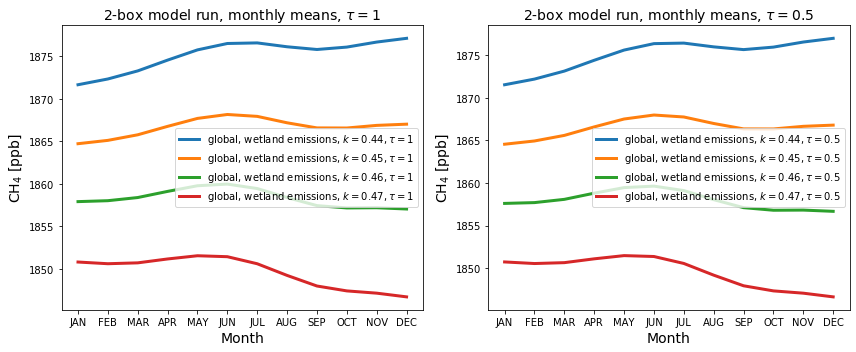

In [49]:

fig = plt.figure(figsize=[6,5])
fig.set_figwidth(fig.get_figwidth() * 2)
# fig.set_figheight(fig.get_figheight() * 2)

ax = fig.add_subplot(1,2,1)
plt.plot(mean_monthly_global_3_1, linewidth=3, label=r'global, wetland emissions, $k=0.44, \tau=1$')
plt.plot(mean_monthly_global_3_2, linewidth=3, label=r'global, wetland emissions, $k=0.45, \tau=1$')
plt.plot(mean_monthly_global_3_3, linewidth=3, label=r'global, wetland emissions, $k=0.46, \tau=1$')
plt.plot(mean_monthly_global_3_4, linewidth=3, label=r'global, wetland emissions, $k=0.47, \tau=1$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, monthly means, $\tau = 1$', fontsize=14)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], months)
plt.tight_layout()

ax = fig.add_subplot(1,2,2)
plt.plot(mean_monthly_global_3_11, linewidth=3, label=r'global, wetland emissions, $k=0.44, \tau=0.5$')
plt.plot(mean_monthly_global_3_21, linewidth=3, label=r'global, wetland emissions, $k=0.45, \tau=0.5$')
plt.plot(mean_monthly_global_3_31, linewidth=3, label=r'global, wetland emissions, $k=0.46, \tau=0.5$')
plt.plot(mean_monthly_global_3_41, linewidth=3, label=r'global, wetland emissions, $k=0.47, \tau=0.5$')
plt.ylabel('CH$_4$ [ppb]', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.legend(loc=0)
plt.title(r'2-box model run, monthly means, $\tau = 0.5$', fontsize=14)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], months)
plt.tight_layout()

plt.tight_layout()
plt.savefig('figures/2_box_LCH4_5_year_monthly_means_wetland_only.pdf')

In [50]:
mean_monthly_nh_3_1 = (ch4_conc_2b_lch4_3_3[0][12:24] + ch4_conc_2b_lch4_3_3[0][24:36]\
               + ch4_conc_2b_lch4_3_3[0][36:48] + ch4_conc_2b_lch4_3_3[0][48:])/4
mean_monthly_sh_3_1 = (ch4_conc_2b_lch4_3_3[1][12:24] + ch4_conc_2b_lch4_3_3[1][24:36]\
               + ch4_conc_2b_lch4_3_3[1][36:48] + ch4_conc_2b_lch4_3_3[1][48:])/4
mean_monthly_global_3_1 = (mean_monthly_nh_3_1 + mean_monthly_sh_3_1) / 2



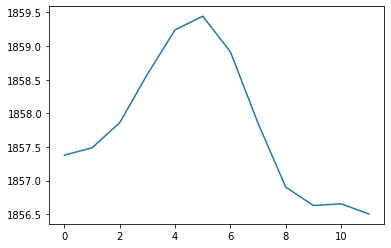

In [51]:
plt.plot(mean_monthly_global_3_1)